# The joint model for Navy CHARM: RI



In [1]:
from datetime import datetime; print("START:", datetime.now())
import socket; print("Simons Foundation, Rusty HPC,", socket.gethostname())

START: 2021-10-24 18:17:17.391606
Simons Foundation, Rusty HPC, worker3124


In [2]:
%cd /mnt/home/zzhang/ceph/CHARM-AlternativeSplicing
%load_ext rpy2.ipython

/mnt/ceph/users/zzhang/CHARM-AlternativeSplicing


In [3]:
# import everything we will need from jemm
from jemm.junction import JunctionCountTable
from jemm.transcript import TranscriptMeasureTable
from jemm.model import JemmLinearRegression, JemmLinearMixedModel
from jemm.plots import facet_boxplot
from jemm.covariate import Contrasts, Covariate

In [4]:
import pickle
import numpy as np
import pandas as pd
import os
import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
plt.style.use(['science', 'no-latex', 'ieee'])


EVENT_TYPE = 'RI'
DATA_VER = 'data-V7'
FDR_THRESH = 0.05
PCS_TO_INCL = '0,6'
# Model method to use
USE_RE = True
MIN_RE_VAR = 0.001
%run ./notebooks/navy_utils.V7.py $DATA_VER $PCS_TO_INCL $USE_RE
#%run run_jem_tests.RI.py
#covs = get_covs(DATA_VER=DATA_VER)

Jemm = JemmLinearMixedModel if USE_RE is True else JemmLinearRegression

OUTDIR = './%s/joint_%s/' % (DATA_VER, EVENT_TYPE)
os.makedirs(OUTDIR, exist_ok=True)

FIGDIR = './%s/joint_%s/figs' % (DATA_VER, EVENT_TYPE)
os.makedirs(FIGDIR, exist_ok=True)


FORCE_RERUN = False
USE_ANNOT = True
DUMP_REDUCED = False

navy_utils.py data-V7 ['PC0', 'PC6'] True


## 1. Load data

In [5]:
JCT = pickle.load(open("./%s/compiled/jct_%s.pkl" % (DATA_VER, EVENT_TYPE), "rb"))
TXR = pickle.load(open("./%s/compiled/txr_%s.pkl" % (DATA_VER, EVENT_TYPE), "rb"))

In [6]:
from jemm.genomic_annotation import ExonSet
#exonset = ExonSet.from_rmats("./data/rmats/fromGTF.%s.txt"%EVENT_TYPE, event_type=EVENT_TYPE)
exonset = ExonSet.from_suppa("/mnt/ceph/users/zzhang/SUPPA/index/hg38/suppa_gencodev34_%s_strict.ioe"%EVENT_TYPE, 
                             cache_dir='./data/',
                             event_type=EVENT_TYPE)
if USE_ANNOT:
    exonset.read_coding_region_from_gtf_by_splice_site('/mnt/home/zzhang/ceph/genome_annotation/gencode.v34.annotation.gtf')
    exonset.read_pfam_domain_from_bed_by_splice_site('./data/pfam/hg38_exon_pfam_annot.bed.gz', 
                                                     clan_annot_fp='./data/pfam/Pfam-A.clans.tsv.gz')
    exonset.read_rbp_clip([
        './data/encode_eclip/hg38_gencodev34.all_splice_sites.encodeIDR.bed',
        './data/encode_eclip/hg38_gencodev34.all_splice_sites.clipdb.bed'
        ])

reloaded 'jemm.genemap.pkl' from cache dir ./data/


## 2. Build joint model

In [7]:
# contrasts and covariates
print("Disease model: %s" % covs.formula)
# init jemm
jem = Jemm(junction_measure=JCT, 
           transcript_measure=TXR, 
           covariates=covs,
           diff_intercept_by_measure=True,
           group_varname='pid',
           min_groupvar=MIN_RE_VAR, 
           optimizer='bfgs'
)
print("Before filter: %i"%len(jem.event_index))
black_list_exons = []
print("Black list=%i"%len(black_list_exons))
jem.event_index = [e for e in jem.event_index if e not in black_list_exons]
print("After filter: %i"%len(jem.event_index))

Disease model: y = final + pid + Sex + PC0 + PC6
Before filter: 7658
Black list=0
After filter: 7658


/mnt/ceph/users/zzhang/RnaSplicingHub/jemm/jemm/model.py:176: UserWarning: Input covariate matrix has condition number = 39865.375010374875 > 100, indicating the presence of co-linearality; optimization might be unstable.
  _ = self._check_covariate_condition()


In [8]:
print('unique pids = %i' % len(jem.covariates.covariate.pid.unique()))
print('total sids = %i' % len(jem.covariates.covariate.index.unique()))

unique pids = 371
total sids = 1176


In [9]:
outfp = os.path.join(OUTDIR, "joint.%s.reg_table.tsv"%EVENT_TYPE)
if FORCE_RERUN is False and os.path.isfile(outfp):
    # reload the results if previous results found
    jem.load_regression_table(outfp=outfp)
else:
    # run tests if cannot find previous results
    _ = jem.run_tests(test_type='Wald',
                      data="txr",
                      force_diff_intercept=False,
                      force_rerun=True,
                      pval_adjust_method="fdr",
                      nthreads=1
                     )
    # if new run, save the results for future re-use
    jem.munge_covariates([
        'final@Pre',
        'final@First',
        'final@Mid',
        'final@Post',
    ],
    meta_name = "final4cond"
    )
    reg_table = jem.save_regression_table(outfp, 
                              exonset=exonset, 
                              annotations=['coding_region', 'pfam_domain', 'rbp_clip'] if USE_ANNOT else None,
                              order_by_covariate='final4cond',
                              order_by='logP'
                             )


/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1847: RuntimeWarning: invalid value encountered in greater_equal
  cond2 = (x >= np.asarray(_b)) & cond0


In [10]:
# Dump reduced version of data for later use
if DUMP_REDUCED:
    tested_eids = [e for e in jem.event_index if e in jem.stats_tests]
    jct_ = jem.junction_measure
    txr_ = jem.transcript_measure
    jct = JunctionCountTable(filepath='./%s/compiled/jct_%s.pkl'% (DATA_VER, EVENT_TYPE), 
                             input_type="plaintext", lazy_init=True)
    jct.data=jct_.loc[[e for e in tested_eids if e in jct_.index]]
    txr = TranscriptMeasureTable(lazy_init=True)
    txr.data=txr_.loc[[e for e in tested_eids if e in txr_.index]]

    import pickle
    pickle.dump(jct, open('./%s/compiled/jct_%s.reduced.pkl'% (DATA_VER, EVENT_TYPE), "wb"))
    pickle.dump(txr, open('./%s/compiled/txr_%s.reduced.pkl'% (DATA_VER, EVENT_TYPE), "wb"))

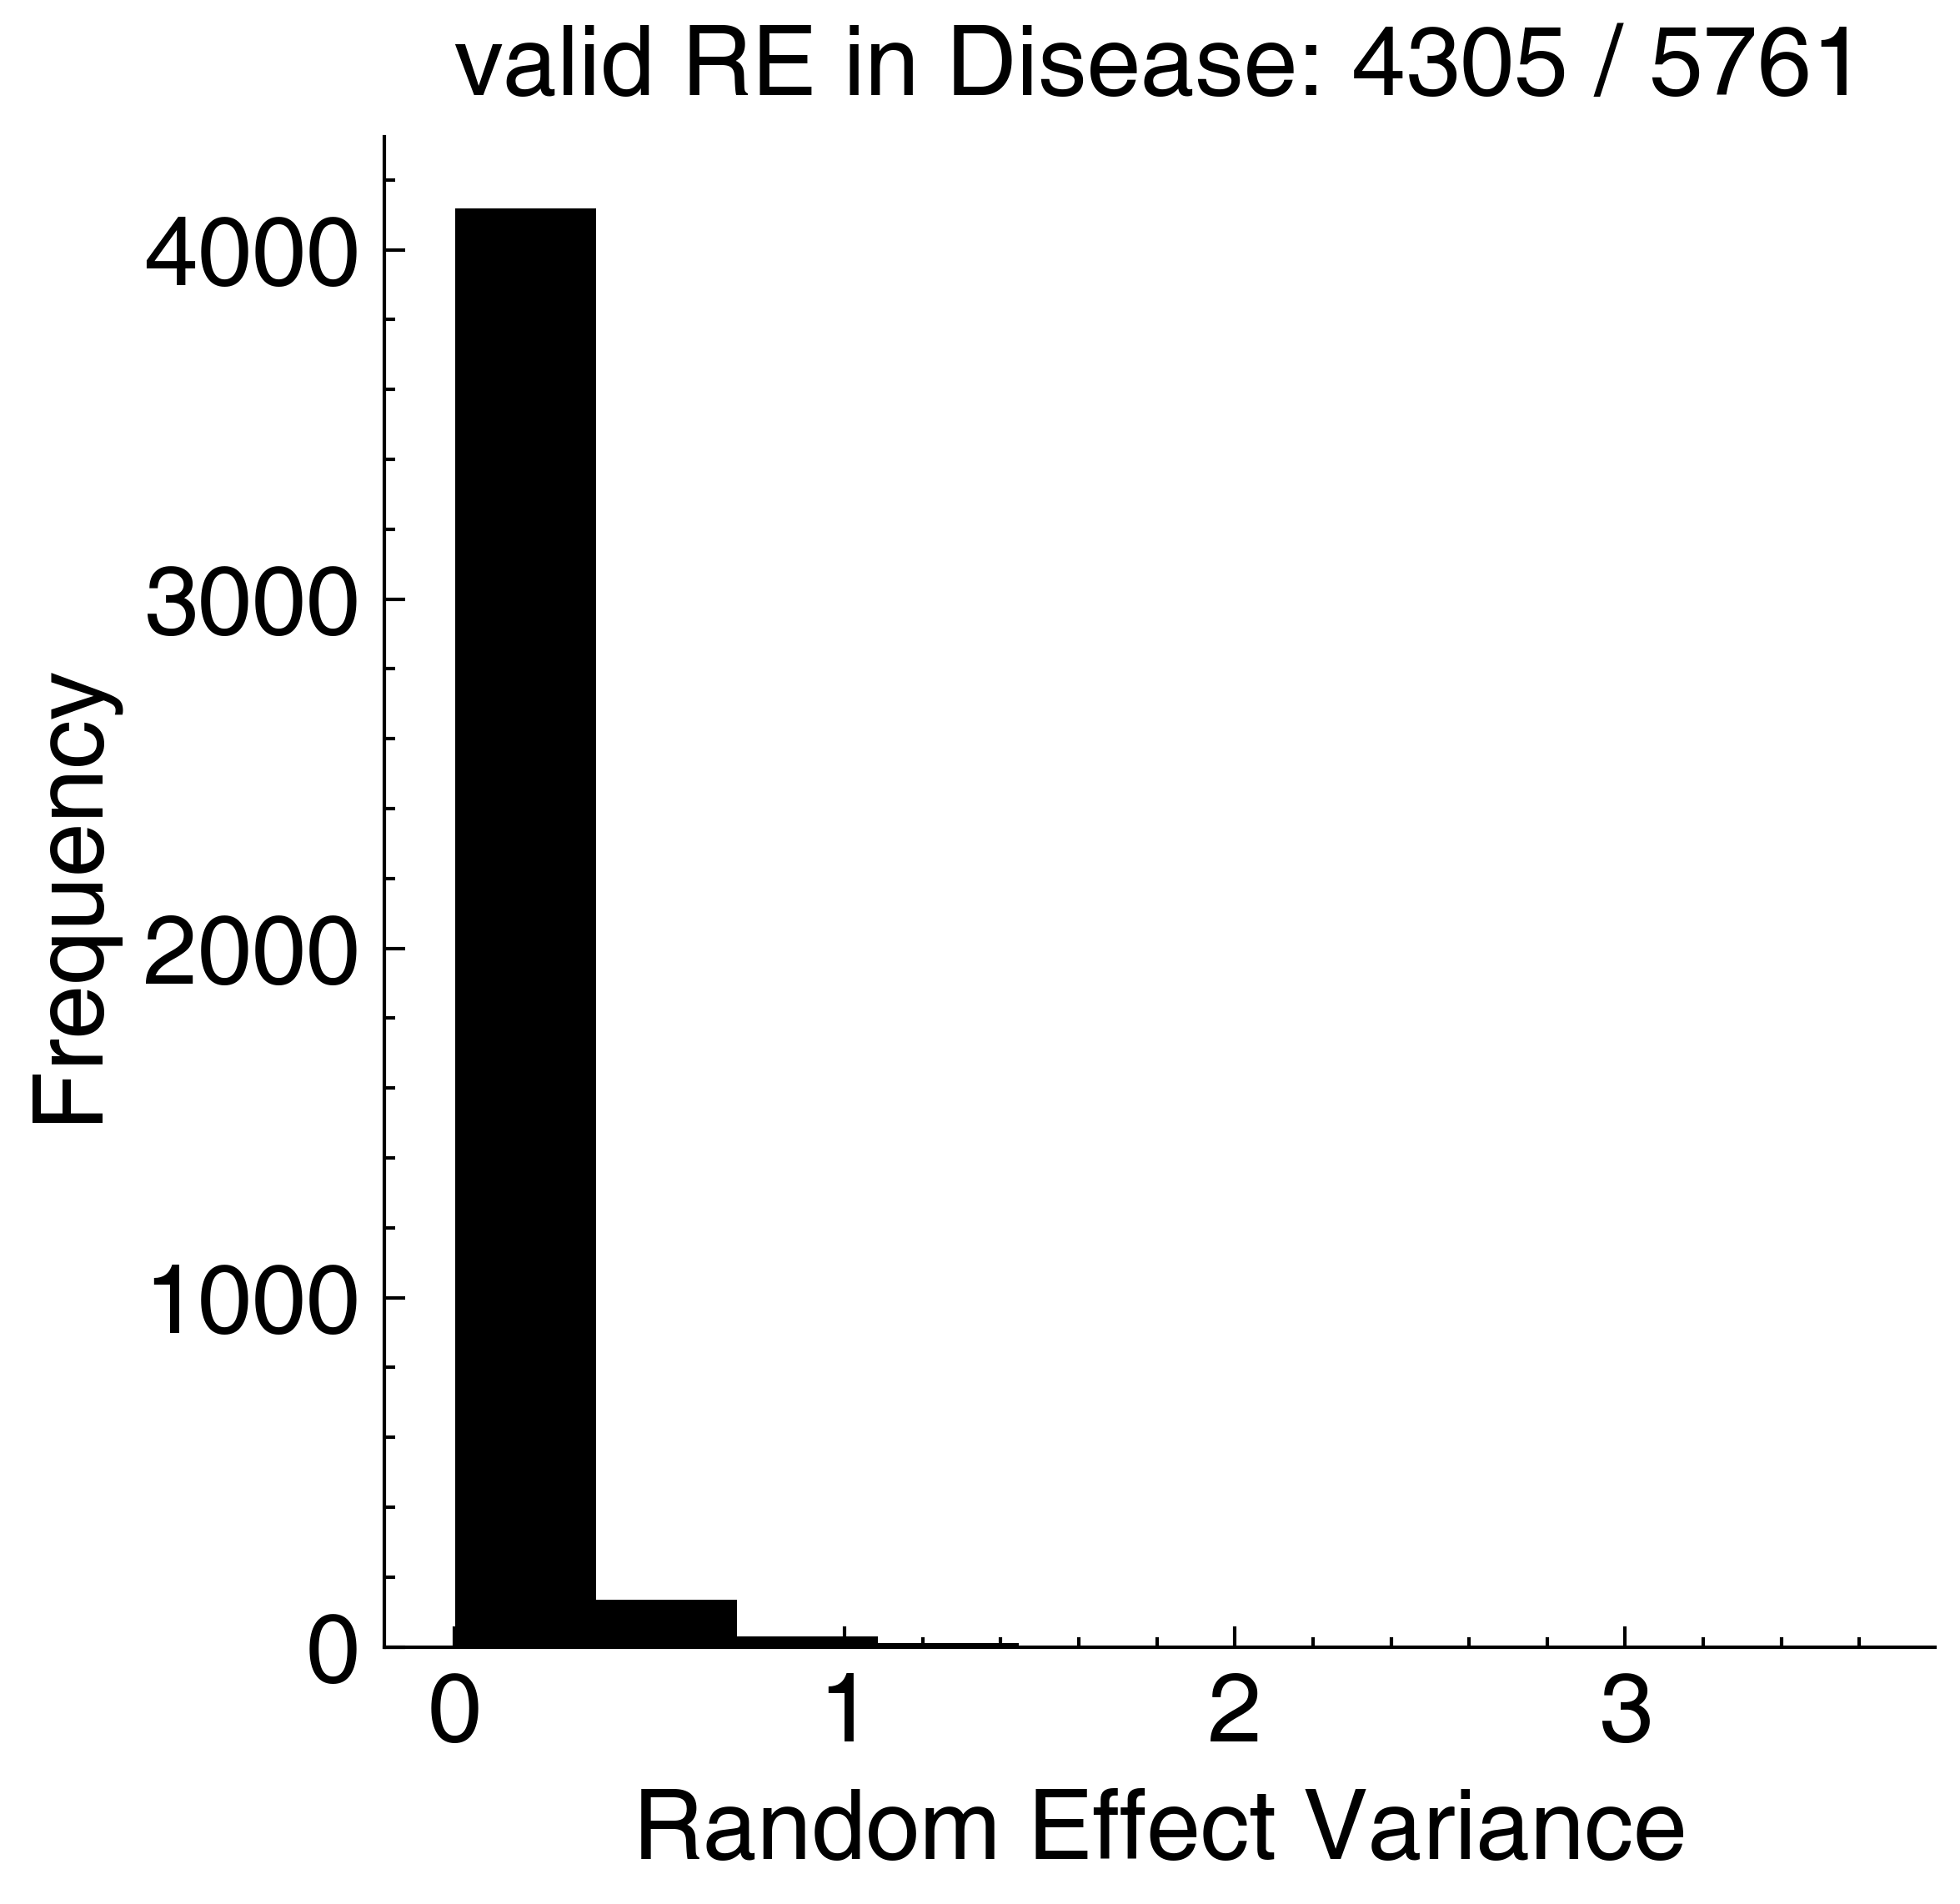

In [11]:
# What's the distribution of Random effect variance estimates?
if USE_RE:
    ax = jem.stats_sheet['pid']['coefs'].plot(kind='hist')
    ax.set_title('valid RE in Disease: %i / %i' % (pd.notna(jem.stats_sheet['pid']['coefs']).sum(), jem.stats_sheet['pid'].shape[0]))
    ax.set_xlabel('Random Effect Variance')
    plt.savefig("%s/03-random_varcomp_disease.pdf" % FIGDIR)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


RI, signif=267/5761
signif & abs.change=42


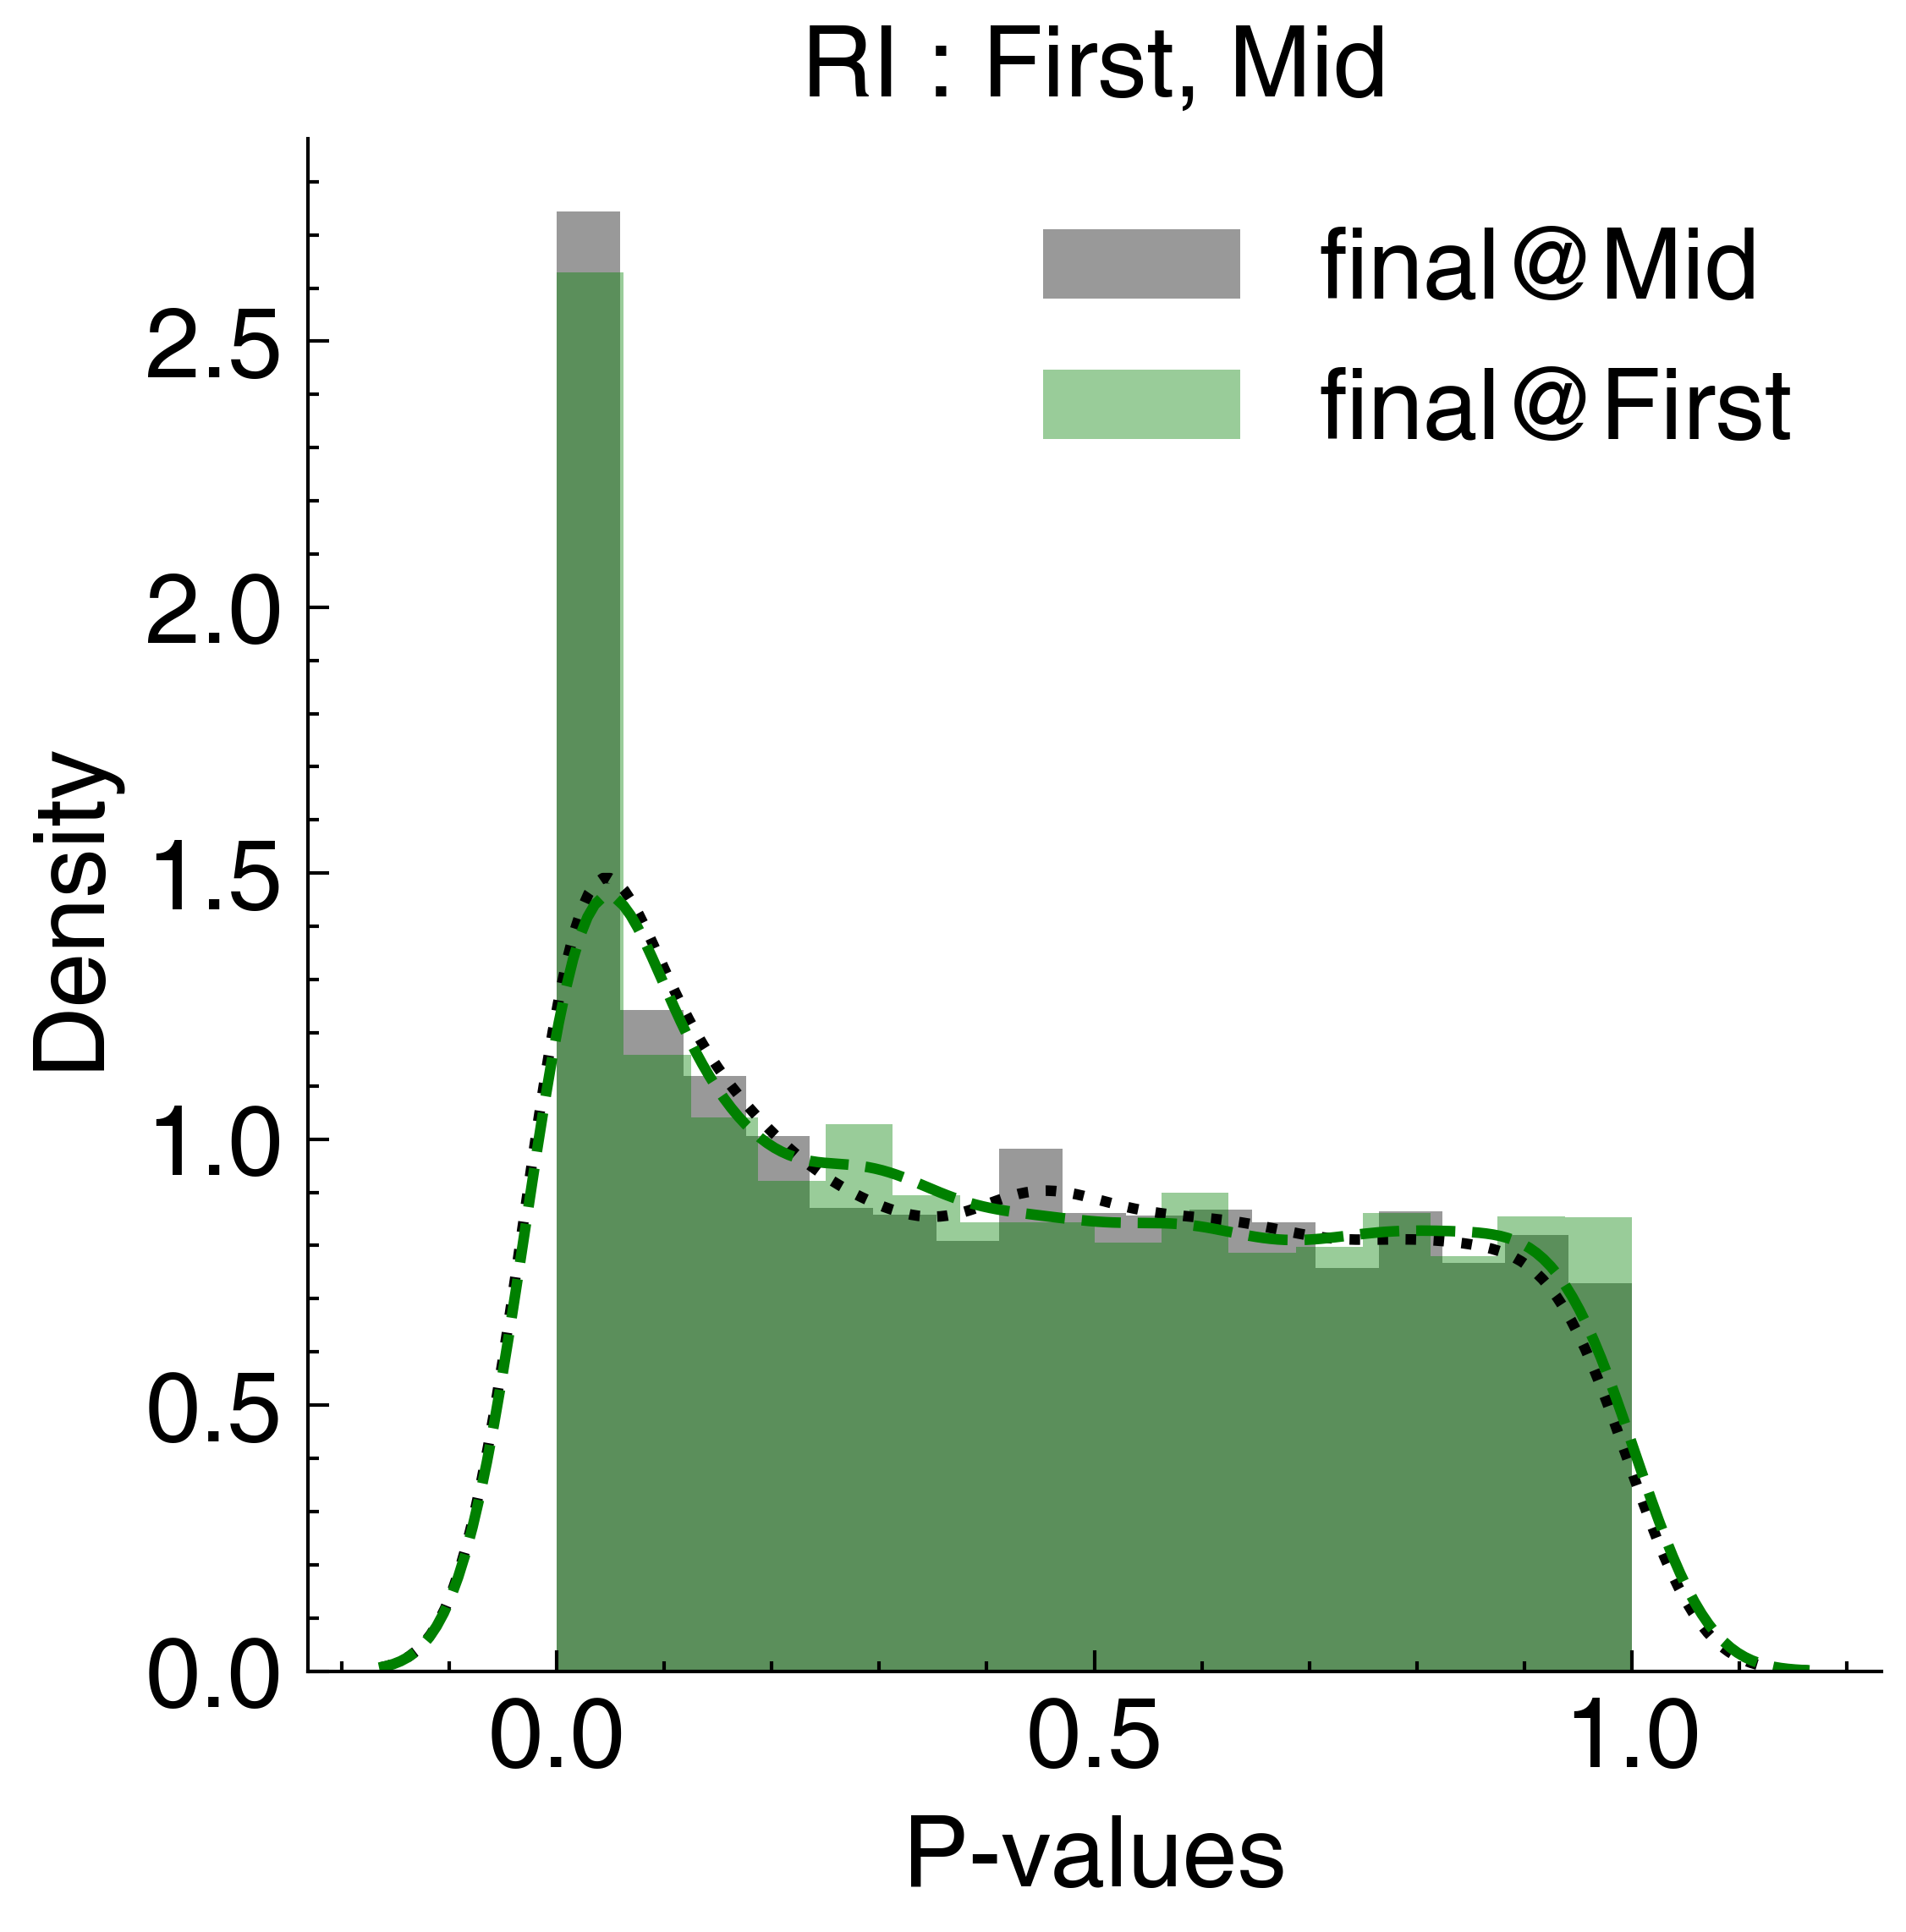

In [12]:
plt.close()
cond = 'final@Mid'
ax1 = sns.distplot(jem.stats_sheet[cond]['pvals'], label=cond)
sns.distplot(jem.stats_sheet['final@First']['pvals'], label="final@First", ax=ax1)
ax1.set_xlabel('P-values')
ax1.legend()
ax1.set_title("%s : First, Mid"%EVENT_TYPE)
plt.savefig("%s/04-pval_distr.pdf" % FIGDIR)

_eids = jem.get_stringent_candidates(contrast_col=cond, qval_thresh=FDR_THRESH, min_change=0.01,
                                         is_consistent_measure=False)
_eids = list(set(_eids))
print("%s, signif=%i/%i"%(EVENT_TYPE, 
    np.sum((
     jem.stats_sheet[cond]['qvals'] < FDR_THRESH)),
     len(jem.stats_tests))
)

print("signif & abs.change=%i" % len(_eids))

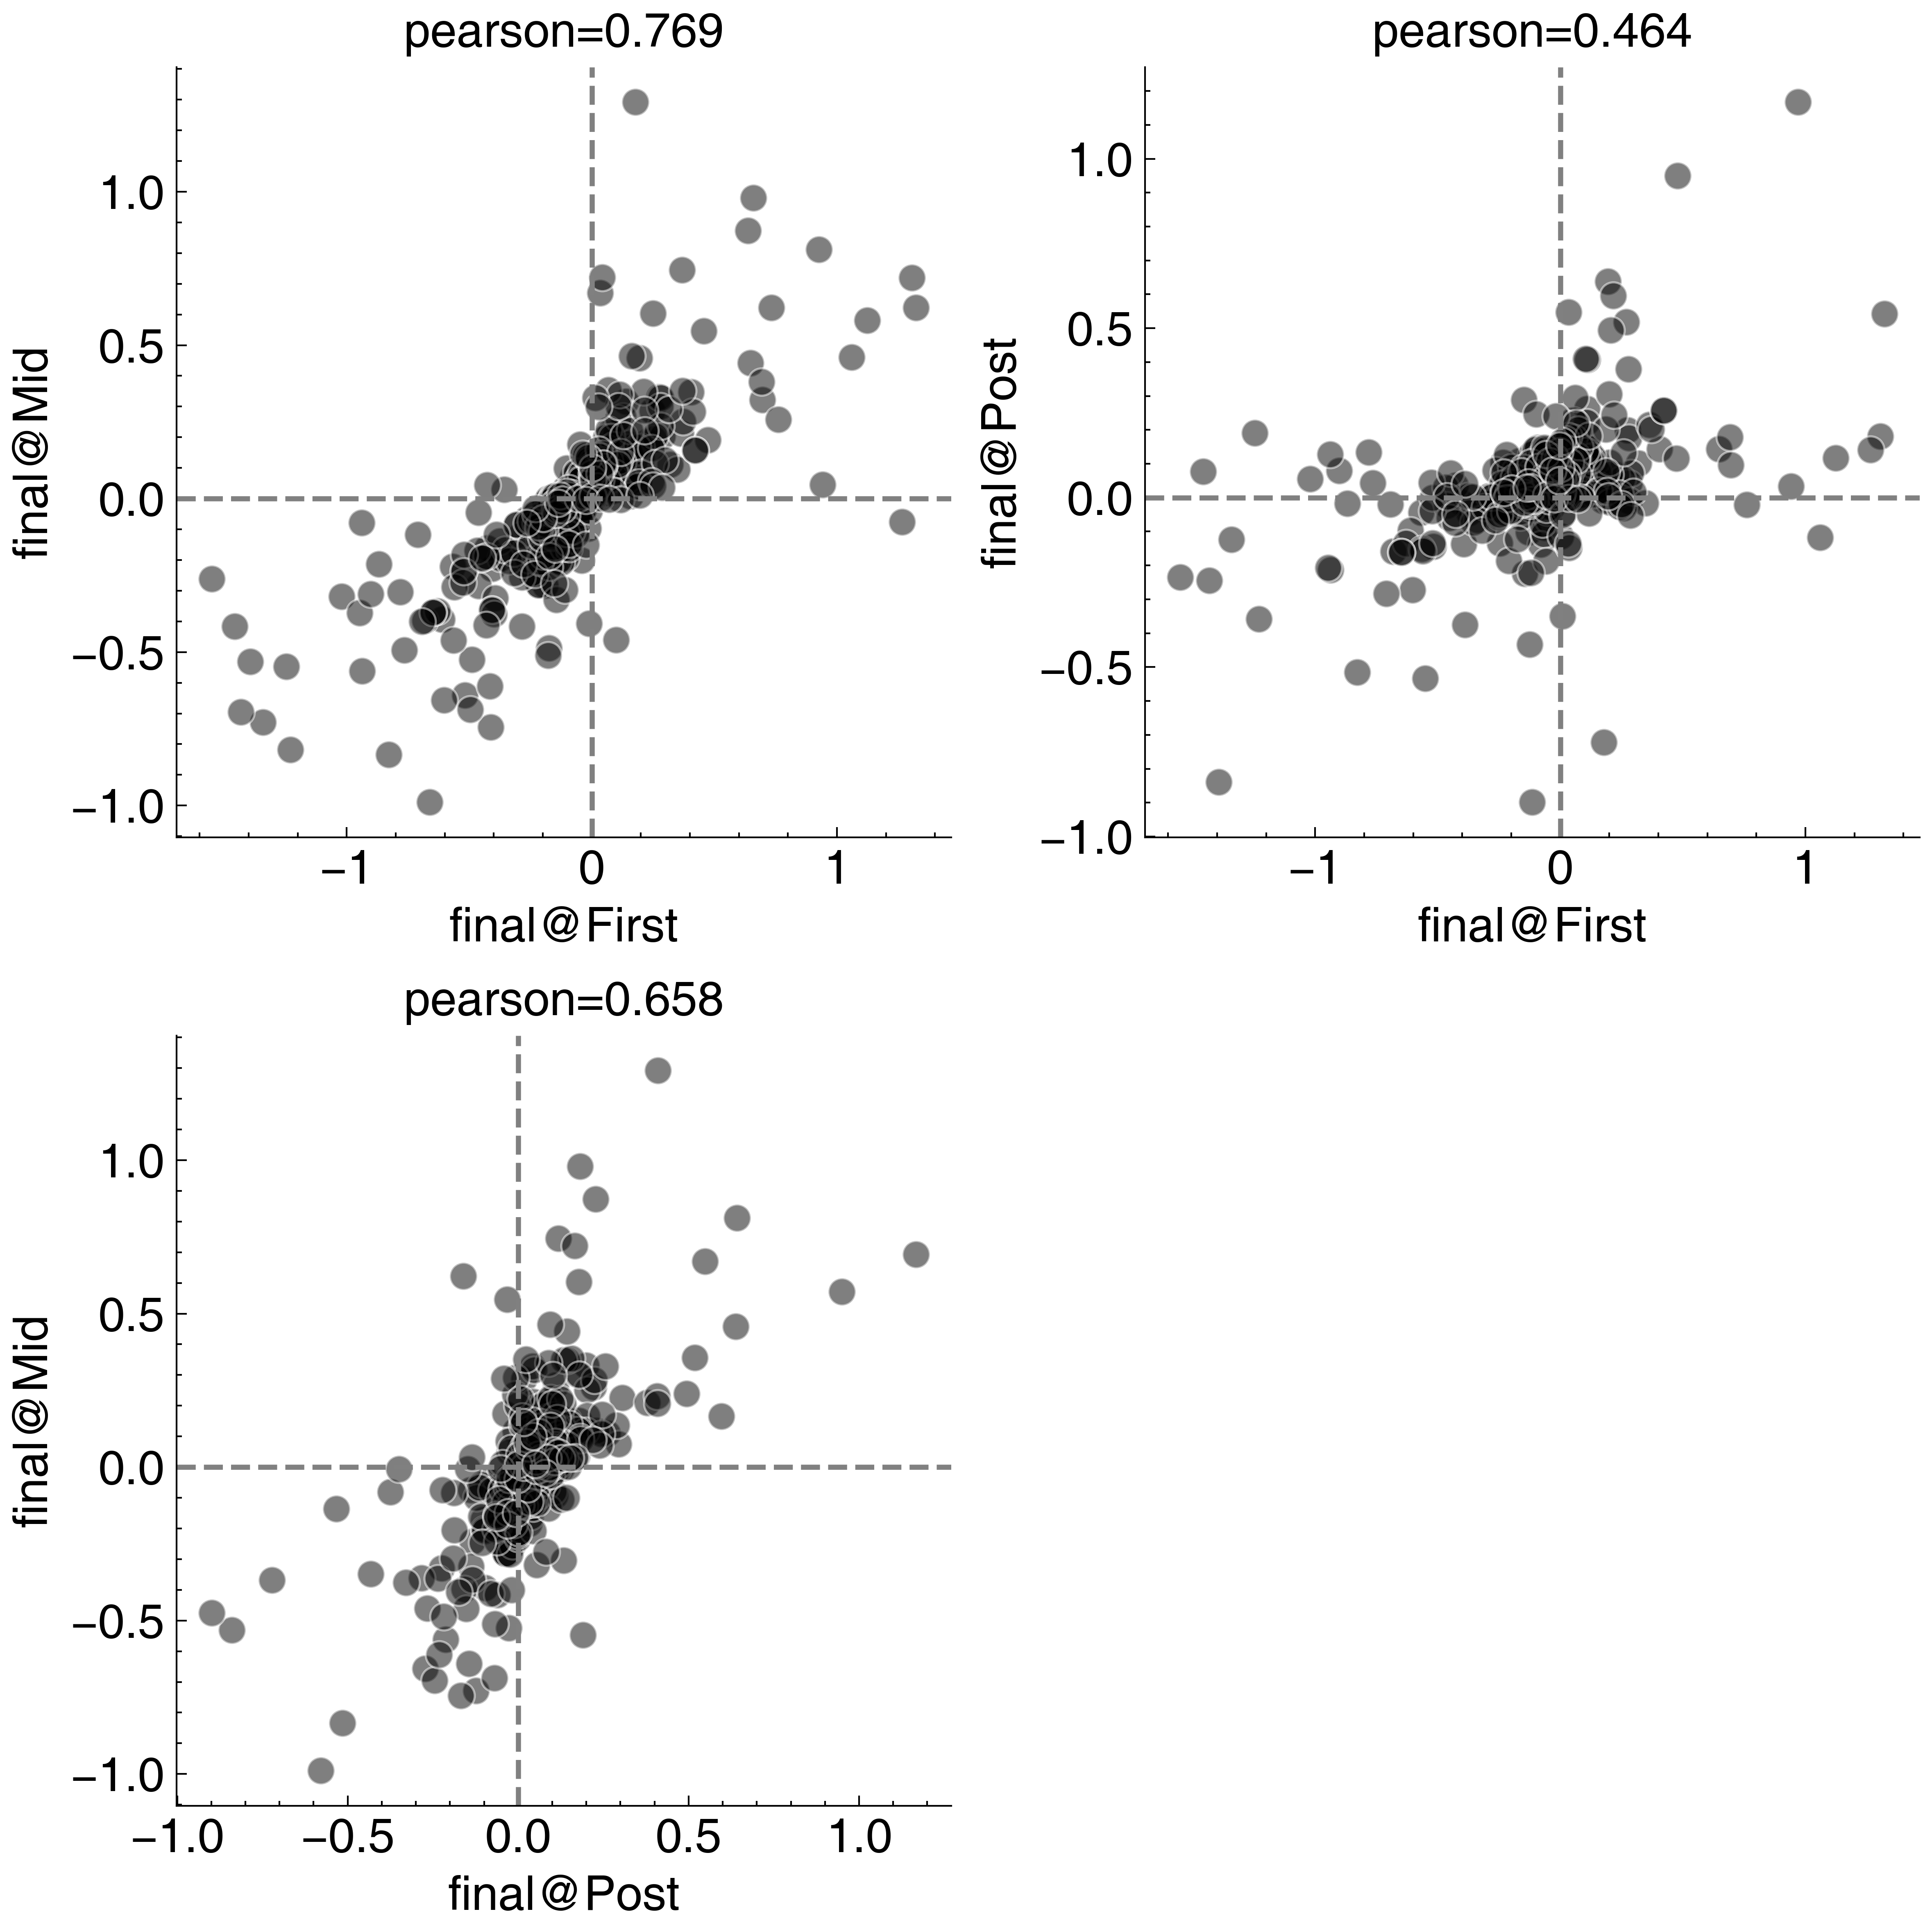

In [13]:
import scipy.stats as ss

xs = ['final@First', 'final@Post']
ys = ['final@Mid', 'final@Post']

comparisons = [(0,0), (0,1), (1,0)]

fig, axs = plt.subplots(2,2, figsize=(8,8))
#fig.suptitle("%s: Time-point comparisons" % EVENT_TYPE)
for i,j in comparisons:
    ax = axs[i,j]
    x = xs[i]
    y = ys[j]
    idx = (jem.stats_sheet[x]['qvals'] < FDR_THRESH ) | (jem.stats_sheet[y]['qvals'] < FDR_THRESH )
    #idx = [x for x in jem.stats_sheet[x].index]
    sns.scatterplot(x=jem.stats_sheet[x].loc[idx, 'coefs'], y=jem.stats_sheet[y].loc[idx, 'coefs'], alpha=0.5, ax=ax)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    #ax.set_title("spearman=%.3f"%ss.spearmanr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs']).correlation)
    ax.set_title("pearson=%.3f"%ss.pearsonr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs'])[0])
    ax.axvline(0, linestyle='--', color="grey")
    ax.axhline(0, linestyle='--', color="grey")
axs[1,1].axis('off')
fig.tight_layout()
fig.savefig("%s/05-timecourse_corr.pdf" % FIGDIR)

In [14]:
jem.stats_sheet.keys()

dict_keys(['intercept', 'final@Asymptomatic', 'final@Exposed', 'final@False Negative', 'final@First', 'final@Immune', 'final@Mid', 'final@Mild', 'final@Moderate', 'final@Post', 'final@Pre', 'final@Reinfection', 'pid', 'Sex@M', 'PC0', 'PC6', '_junc_diff_'])

In [15]:
finals = {x:covs.factor_conversion['final'][x] for x in ['Pre', 'First', 'Mid', 'Post']}
coef_cor_mat = np.zeros((len(finals), len(finals)))

obs = [x for x in finals]
for i in range(len(finals)):
    x = finals[obs[i]]
    for j in range(i, len(finals)):
        y = finals[obs[j]]
        idx = (jem.stats_sheet[x]['qvals'] < FDR_THRESH ) | (jem.stats_sheet[y]['qvals'] < FDR_THRESH)
        #idx = [a for a in jem.stats_sheet[x].index] 
        #this_cor = ss.spearmanr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs']).correlation
        try:
            this_cor = ss.pearsonr(jem.stats_sheet[x].loc[idx, 'coefs'], jem.stats_sheet[y].loc[idx, 'coefs'])[0]
        except ValueError:
            this_cor = 0
        coef_cor_mat[i,j] = this_cor
        coef_cor_mat[j,i] = this_cor
coef_cor_df = pd.DataFrame(coef_cor_mat, columns=obs, index=obs)
coef_cor_df

Pre     First       Mid      Post
Pre    1.000000  0.368931  0.618314  0.855434
First  0.368931  1.000000  0.769134  0.463857
Mid    0.618314  0.769134  1.000000  0.657501
Post   0.855434  0.463857  0.657501  1.000000

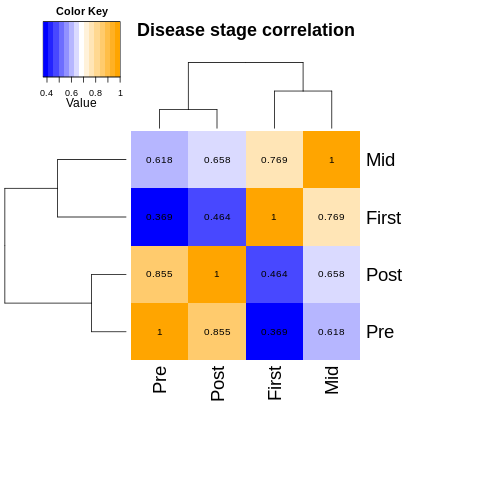

In [16]:
%%R -i coef_cor_df -i FIGDIR
source("R/heatmap.3.R")
y = coef_cor_df
#hr <- hclust(as.dist(1-cor(t(y), method="pearson", use="complete")), method="average")
#hc <- hclust(as.dist(1-cor(y, method="pearson", use="complete")), method="average")
hr <- hclust(dist(y, method="euclidean"), method="average")
hc <- hclust(dist(t(y), method="euclidean"), method="average")

palette <- colorRampPalette(c("blue","white","orange"))

pdf(file.path(FIGDIR, '06-disease_stage_corr.pdf'))
heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "both", col = palette,
  key = TRUE,
  cellnote = round(coef_cor_df, 3),
  notecol = "black",
  main="Disease stage correlation",
  margins=c(10,10)
)
dev.off()
heatmap.3(y, Rowv = as.dendrogram(hr), Colv = as.dendrogram(hc), dendrogram = "both", col = palette,
  key = TRUE,
  cellnote = round(coef_cor_df, 3),
  notecol = "black",
  main="Disease stage correlation",
  margins=c(10,10)
)

In [17]:
from jemm.utils import logit

def get_N_color(number_of_colors, seed=None):
    np.random.seed(seed)
    color = ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)])
                 for i in range(number_of_colors)]
    #print(color)
    return color

contrast_col = 'final@First'
target_eids = jem.get_stringent_candidates(contrast_col=contrast_col, qval_thresh=FDR_THRESH, min_change=0.)

psi_jct = jem.junction_measure.reindex(target_eids).applymap(lambda x: logit(x.psi) if pd.notna(x) else None)
psi_txr = jem.transcript_measure.reindex(target_eids).applymap(lambda x: logit(x.psi) if pd.notna(x) else None)

clab = jem.covariates.get_design_mat(['final'])
clab.rename(columns={x:x.split('@')[1] for x in clab.columns}, inplace=True)
rowsum = clab.apply(np.sum, 1)
clab['Control'] = 0
clab.loc[rowsum==0, 'Control'] = 1
# only focus on a few annotations
samp_index = np.where( (clab['Control']==1) | (clab[contrast_col.split('@')[1]]==1) )[0]
#samp_index = np.arange(clab.shape[0])

clab = clab.replace({1:'navyblue', 0:'white'})
clab = clab[['Control', contrast_col.split('@')[1]]]
clab['Plate'] = [covs.meta.loc[i, 'plateNum'] for i in clab.index]

uniq_vals = clab['Plate'].unique()
palette = get_N_color(len(uniq_vals), seed=777)
mapper = {uniq_vals[i]:palette[i] for i in range(len(uniq_vals))}
clab['Plate'] = clab['Plate'].apply(lambda x: mapper[x]) 

jct_plot = psi_jct.iloc[:, samp_index]
txr_plot = psi_txr.iloc[:, samp_index]
clab_plot = clab.iloc[samp_index]
txr_plot.head(3)

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

20_0149-T00  20_0150-T00  \
chr19:+:2271384:2271530:2271781:2271954            1.381734     1.606370   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_0151-T00  20_0152-T00  \
chr19:+:2271384:2271530:2271781:2271954            1.534902     1.273262   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_0152-T28  20_0152-T53  \
chr19:+:2271384:2271530:2271781:2271954            1.488133     1.662410   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.843682   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_0153-T00  20_0154-T00  \
chr19:+:2271384:2271530:2271781:2271954            1.308311     1.279633   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_0155-T00  20_0156-T00  ...  \
chr19:+:2271384:2271530:2271781:2271954            1.300570     1.108153  ...   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439  ...   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439  ...   

                                                20_2303-T00  20_2305-T00  \
chr19:+:2271384:2271530:2271781:2271954            1.638173     1.671061   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.467319   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_2311-T00  20_2341-T00  \
chr19:+:2271384:2271530:2271781:2271954            1.772509     1.344709   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_2425-T00  20_2430-T00  \
chr19:+:2271384:2271530:2271781:2271954            2.083702     1.400902   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439   
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.944439   

                                                20_2430-T35  20_2461-T00  \
chr19:+:2271384:2271530:2271781:2271954            1.685685     2.122718   
chr2:+:216499948:216500031:216501340:216501467    -2.944439    -2.944439   
chr6:+:35468946:35469027:35469380:35469529        -2.905093    -2.944439   

                                                20_2485-T00  20_2512-T00  
chr19:+:2271384:2271530:2271781:2271954            1.558148     1.337823  
chr2:+:216499948:216500031:216501340:216501467    -2.903511    -2.944439  
chr6:+:35468946:35469027:35469380:35469529        -2.944439    -2.849433  

[3 rows x 278 columns]

[1]  57 278
filled_na= 1114 
[1] 57
[1]  57 278
[1]  57 278
filled_na= 1114 
[1] 57
[1]  57 278


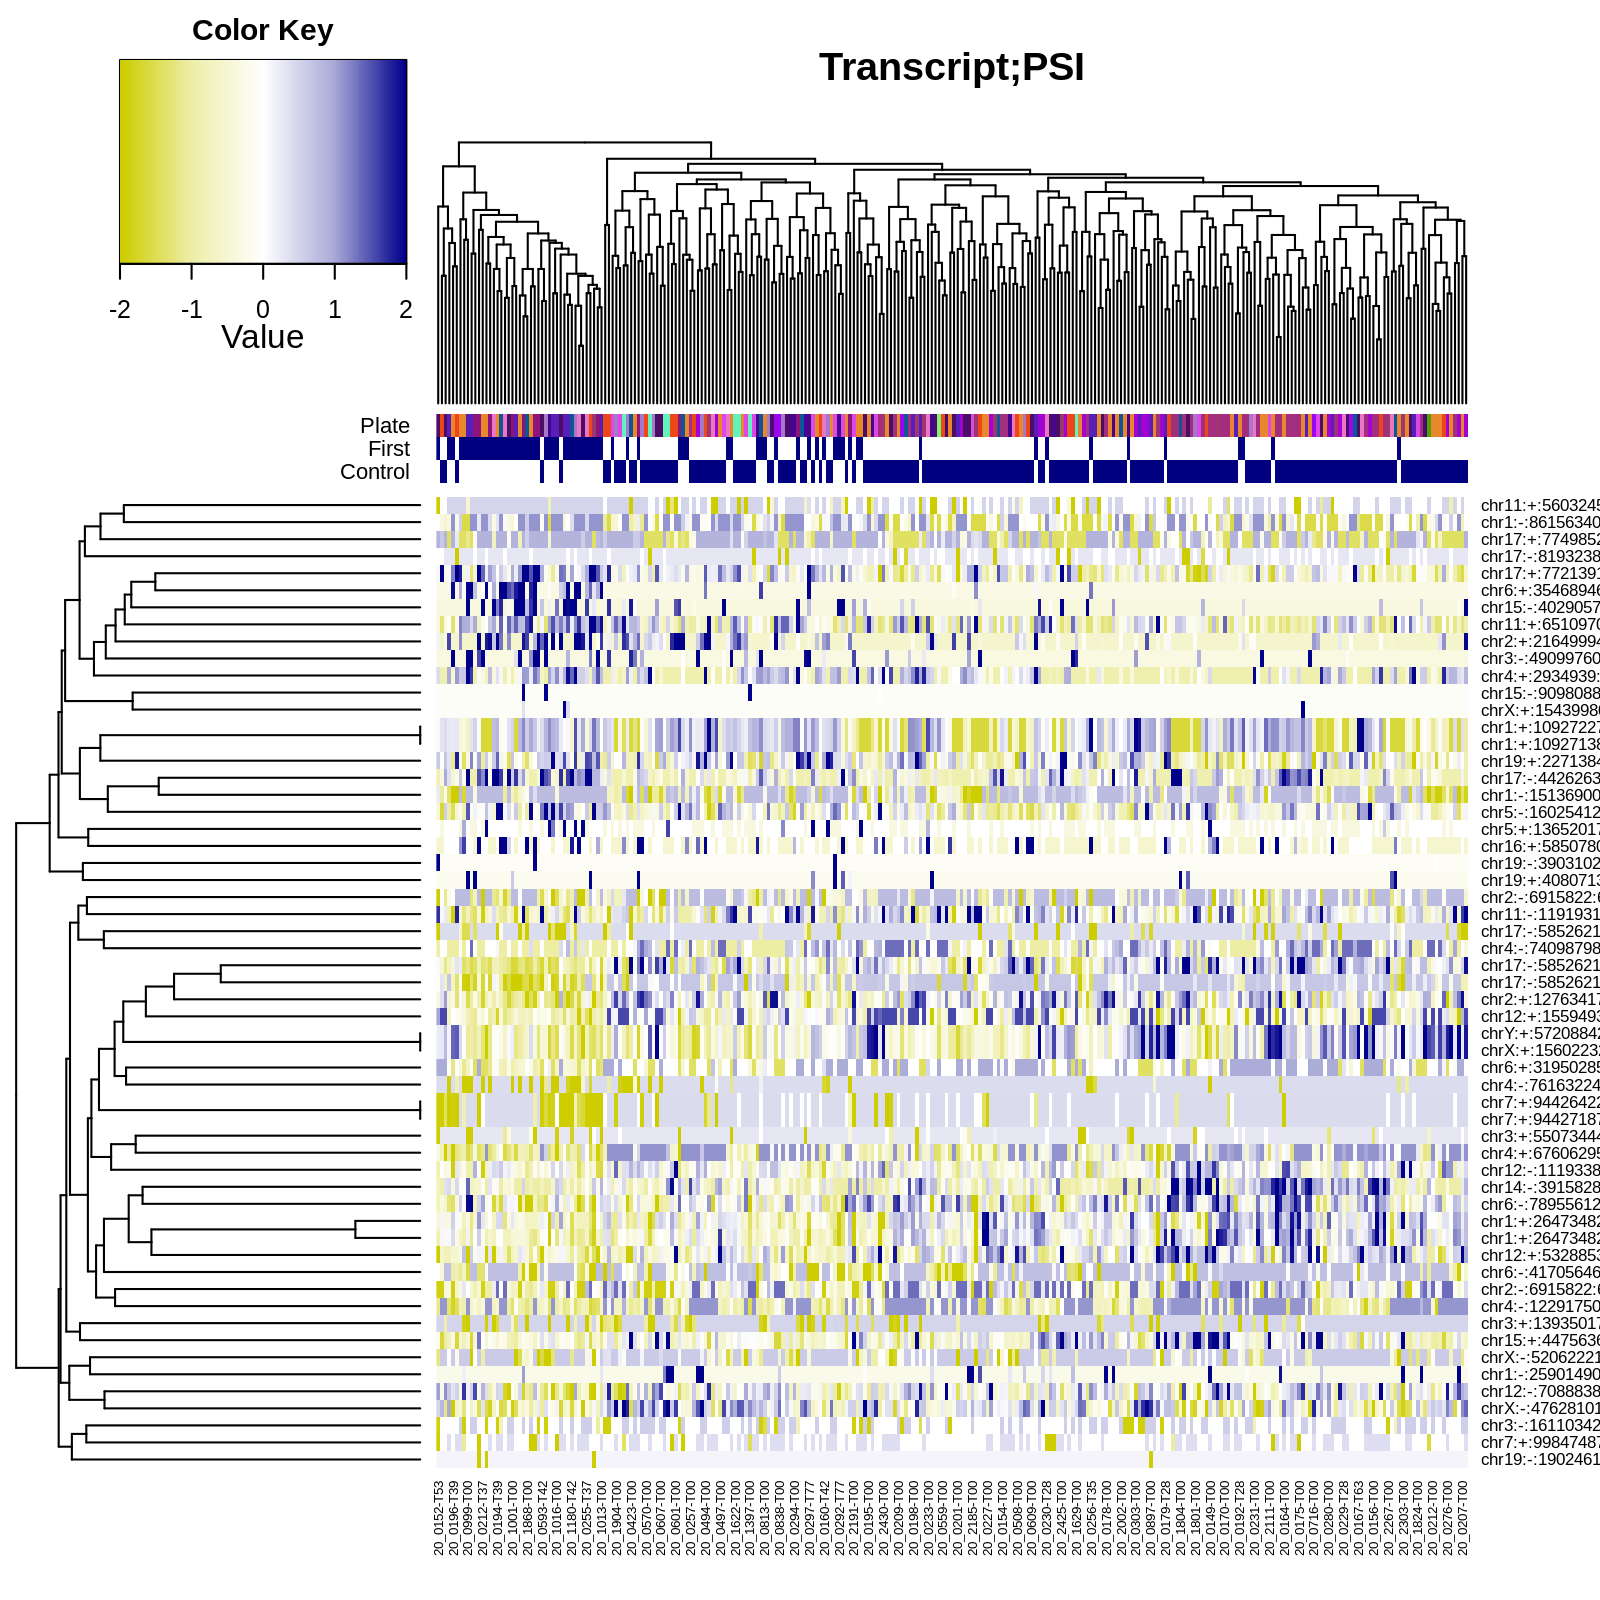

In [18]:
%%R -i txr_plot -i clab_plot -w 8 -h 8 --units in -r 200
source('notebook/navy_utils.R')
pdf(file.path(FIGDIR, "07-First_Txr_cluster.pdf"), width=5, height=8)
g = plot_heatmap(txr_plot, clab_plot, main="Transcript;PSI", do_scale=T)
dev.off()
g = plot_heatmap(txr_plot, clab_plot, main="Transcript;PSI", do_scale=T)

## 3. Get the high-confidence events

Definition of "high-confidence":
- "significant" as qval<0.05

In [19]:
print('Sig count:')
pd.DataFrame(jem.get_das_cnt(target_covariate='final', qval_thresh=FDR_THRESH), index=[EVENT_TYPE])

Sig count:


Asymptomatic  Exposed  False Negative  First  Immune  Mid  Mild  Moderate  \
RI           232       67               9    242       4  267   124        92   

    Post  Pre  Reinfection  
RI   225   21           13

In [20]:
target_contrasts = [
    'final@Pre',
    'final@First',
    'final@Mid',
    'final@Post',
    #'final@False Negative',
    #'final@Immune'
]
covs.meta['final'].value_counts()

Post              334
Mid               254
Control           206
Asymptomatic       80
First              72
Mild               54
Pre                48
Moderate           43
Exposed            38
Immune             25
False Negative     17
Reinfection         5
Name: final, dtype: int64

In [21]:
event_catelog = defaultdict(dict)

for eid in jem.stats_tests:
    target_ = jem.stats_tests[eid].loc[target_contrasts]
    target_ = target_.loc[target_['qvals']<FDR_THRESH]['coef'].to_dict()
    if len(target_):
        event_catelog[eid] = target_


In [22]:
up_catelog = {}
dn_catelog = {}
for eid in event_catelog:
    ups = [x for x in event_catelog[eid] if event_catelog[eid][x]>0]
    dns = [x for x in event_catelog[eid] if event_catelog[eid][x]<0]
    if len(ups) >= 1:
        up_catelog[eid] = ups
    if len(dns) >= 1:
        dn_catelog[eid] = dns


print("Upregulated n=%i"%len(up_catelog))
print("Downregulated n=%i"%len(dn_catelog))

Upregulated n=323
Downregulated n=247


In [23]:
# store all sig. events
das_up_eids = [e for e in up_catelog]
das_dn_eids = [e for e in dn_catelog]
das_eids = list(set(das_up_eids + das_dn_eids))

In [24]:
# "high-contrast" events should be very few
high_contrasts = [e for e in up_catelog if e in dn_catelog]
print("High-contrast n=%i"%len(high_contrasts))

High-contrast n=23


## 4. Annotate the DAS events and genes

(323, 2)


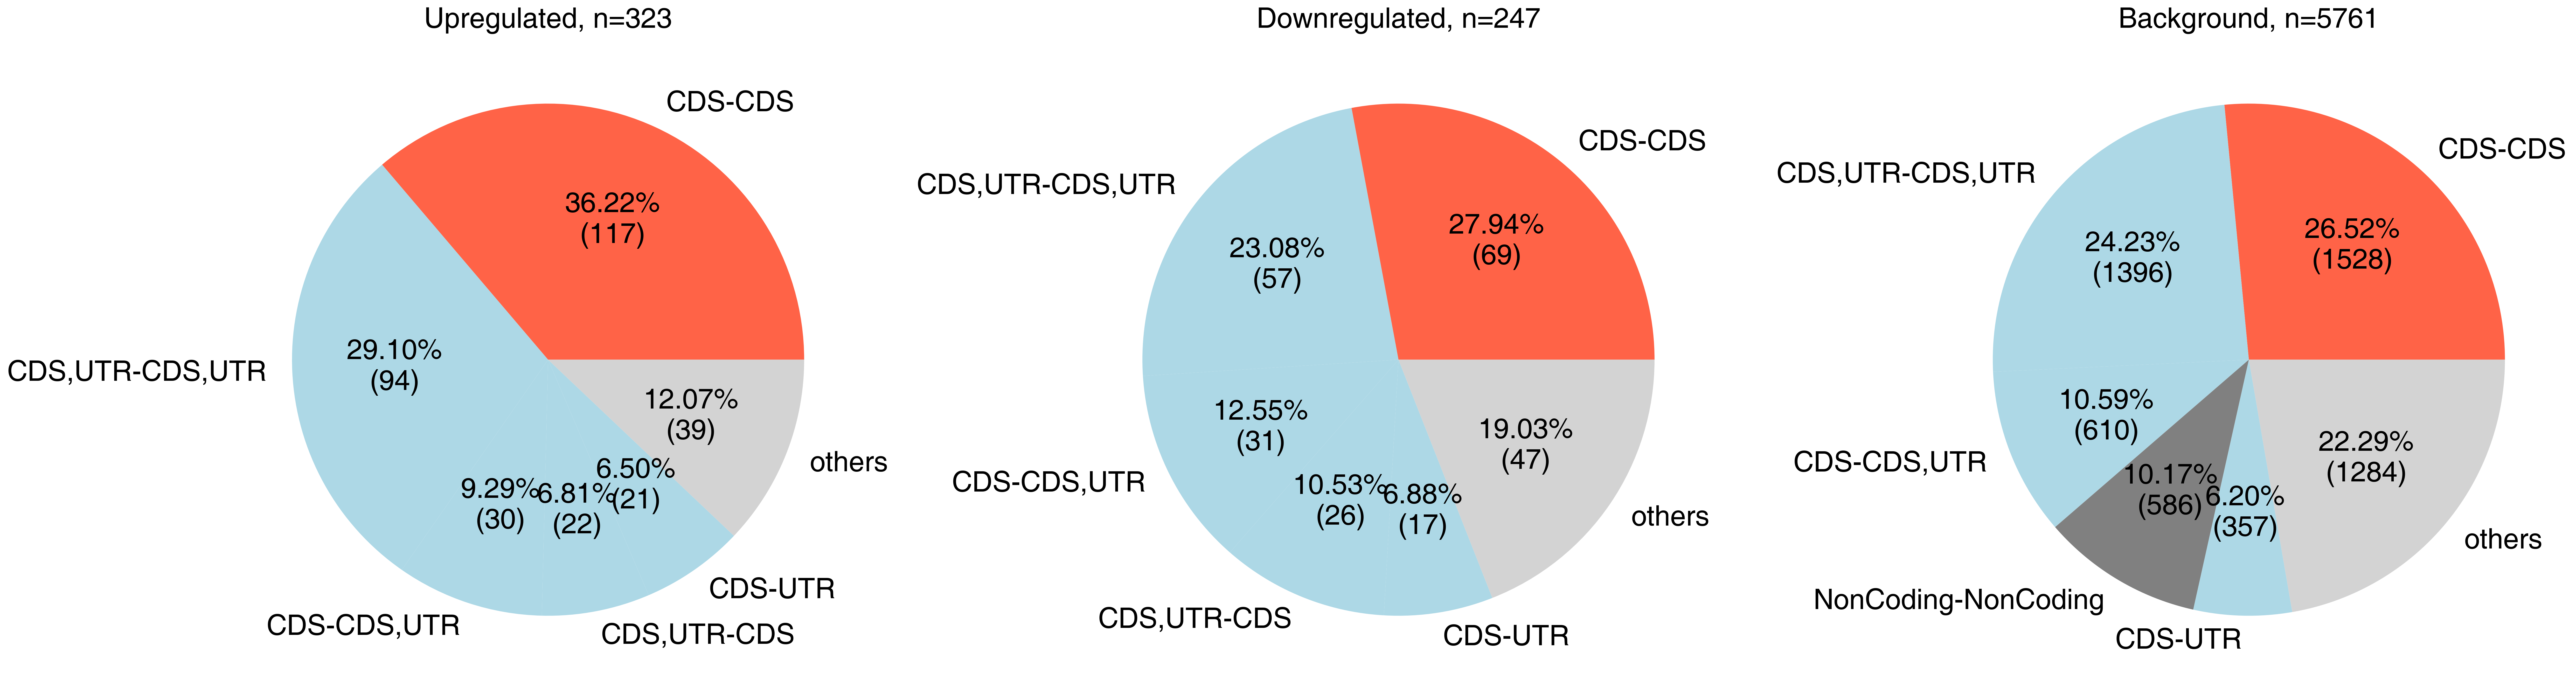

In [25]:
if USE_ANNOT:
    # Get annotation
    das_up_exons = exonset.get_splice_site_annotations(eids=das_up_eids, annotations=['coding_region', 'pfam_domain'])
    das_dn_exons = exonset.get_splice_site_annotations(eids=das_dn_eids, annotations=['coding_region', 'pfam_domain'])
    bg = exonset.get_splice_site_annotations(eids=[e for e in jem.stats_tests], annotations=['coding_region'])

    print(das_up_exons.shape)

    # Replace undef
    unannot = [
        x for x in bg['coding_region'].unique() 
        if 'NonCoding' in x
        and x != 'NonCoding-NonCoding']
    das_up_exons['coding_region'].replace(to_replace=unannot, value='Unannot', inplace=True)
    das_dn_exons['coding_region'].replace(to_replace=unannot, value='Unannot', inplace=True)

    # Plot
    def color_maker(k):
        c = 'lightgrey'
        if 'CDS' in k:
            c = 'tomato'
        if 'UTR' in k:
            c = 'khaki'
        if 'CDS' in k and 'UTR' in k:
            c = 'lightblue'
        if k == 'NonCoding-NonCoding':
            c = 'grey'
        return c

    color_map = {k: color_maker(k) for k in bg['coding_region'].unique()}


    def make_autopct(values):
        def my_autopct(pct):
            total = sum(values)
            val = int(round(pct*total/100.0))
            return '{p:.2f}%\n({v:d})'.format(p=pct,v=val)
        return my_autopct


    fig, axs = plt.subplots(1, 3, figsize=(18,54))

    up_das_cnt = das_up_exons['coding_region'].value_counts()
    others = up_das_cnt.iloc[5:].sum()
    up_das_cnt = up_das_cnt.head(5)
    up_das_cnt['others'] = others
    up_das_color = [color_map[x] if x in color_map else 'lightgrey' for x in up_das_cnt.index]
    up_das_cnt.plot.pie(colors=up_das_color, autopct=make_autopct(up_das_cnt), fontsize=14, label="Upregulated", ax=axs[0])
    axs[0].set_title('Upregulated, n=%i'%up_das_cnt.sum())
    axs[0].set_ylabel('')

    dn_das_cnt = das_dn_exons['coding_region'].value_counts()
    others = dn_das_cnt.iloc[5:].sum()
    dn_das_cnt = dn_das_cnt.head(5)
    dn_das_cnt['others'] = others
    dn_das_color = [color_map[x] if x in color_map else 'lightgrey' for x in dn_das_cnt.index]
    dn_das_cnt.plot.pie(colors=dn_das_color, autopct=make_autopct(dn_das_cnt), fontsize=14, label="Upregulated", ax=axs[1])
    axs[1].set_title('Downregulated, n=%i'%dn_das_cnt.sum())
    axs[1].set_ylabel('')

    bg['coding_region'].replace(to_replace=unannot, value='Unannot', inplace=True)
    bg_cnt = bg['coding_region'].value_counts()
    bg_cnt = bg['coding_region'].value_counts()    
    others = bg_cnt.iloc[5:].sum()
    bg_cnt = bg_cnt.head(5)
    bg_cnt['others'] = others
    bg_color = [color_map[x] if x in color_map else 'lightgrey' for x in bg_cnt.index]
    bg_cnt.plot.pie(colors=bg_color, autopct=make_autopct(bg_cnt), fontsize=14, label="All tested", ax=axs[2])
    axs[2].set_title('Background, n=%i'%bg_cnt.sum())
    axs[2].set_ylabel('')
    
    fig.tight_layout()
    fig.savefig("%s/08-CDS_piecharts.pdf" % FIGDIR)
    plt.show()
else:
    print('Skipped Annot')

## 4.1 Splice site annotations
Now make the plots for exon annotations

/mnt/home/zzhang/workspace/programs/anaconda3/envs/rna-seq/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


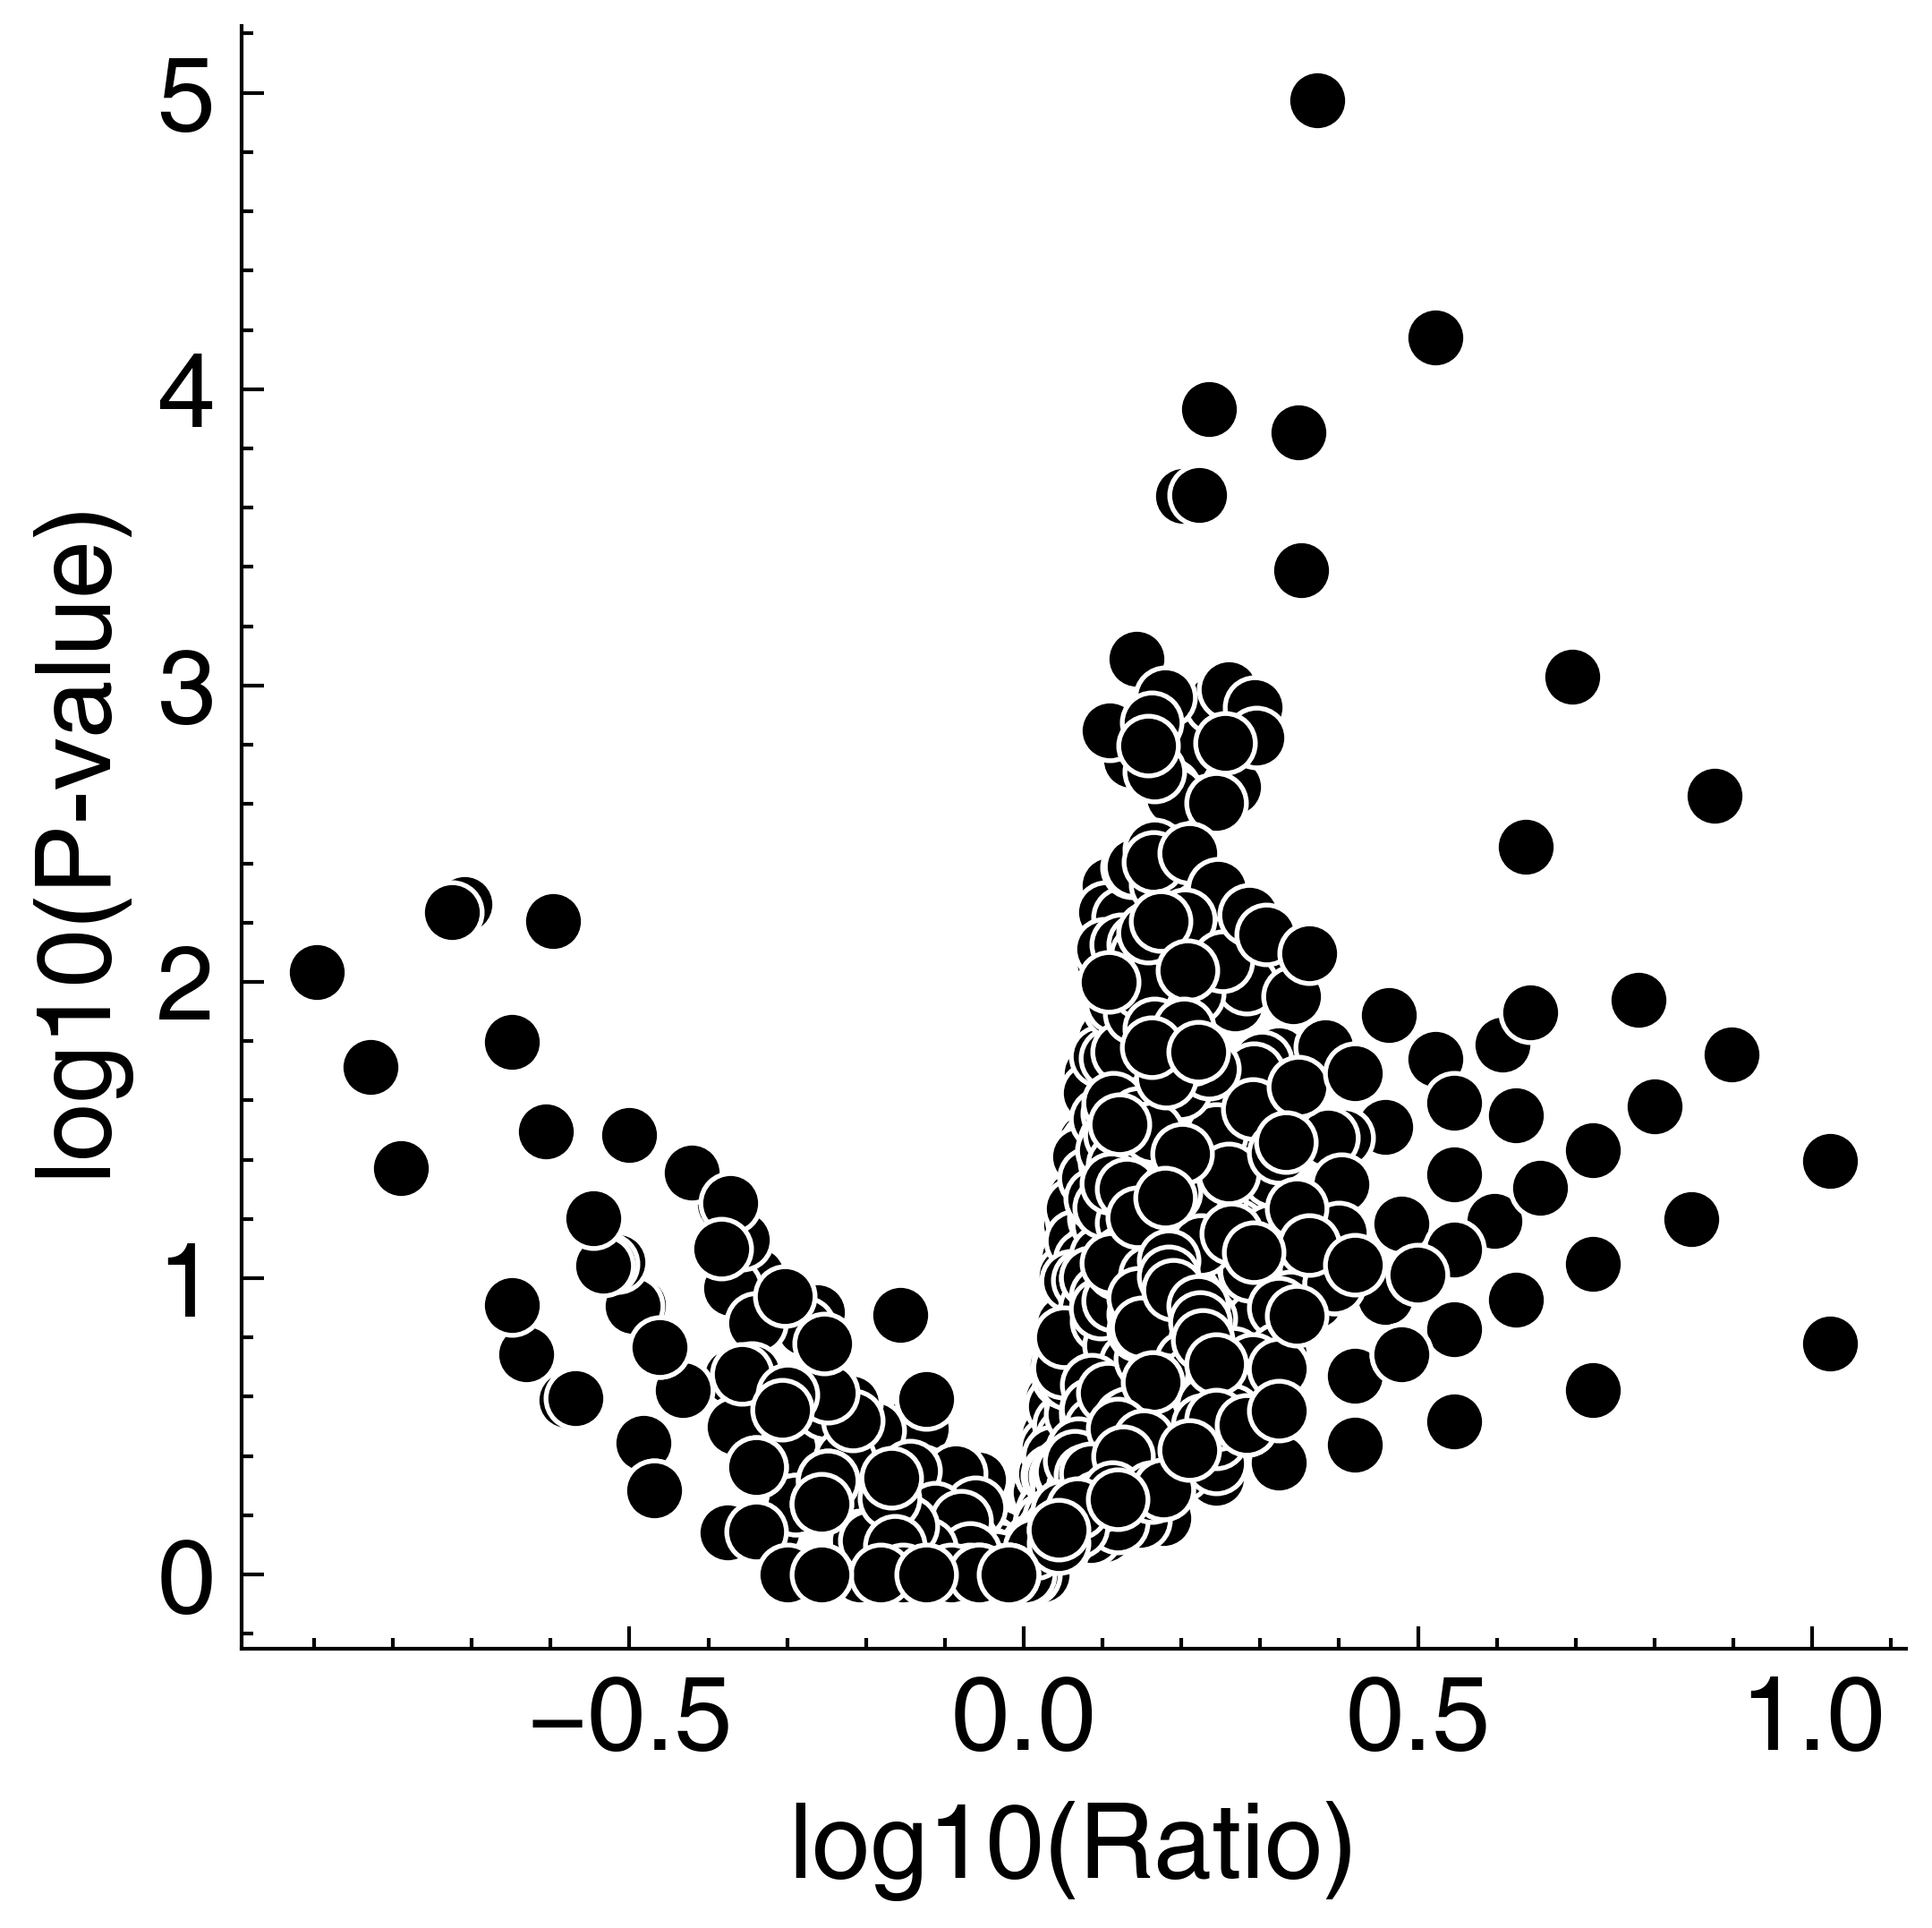

In [26]:
if USE_ANNOT:
    das_annot = exonset.get_splice_site_annotations(eids=das_eids, annotations=['rbp_clip', 'pfam_domain'])
    bg_annot = exonset.get_splice_site_annotations(eids=[e for e in jem.stats_tests], annotations=['rbp_clip','pfam_domain'])
    from collections import Counter
    from jemm.utils import fdr_bh
    das_cnts = Counter([clip for eid_clip in das_annot['rbp_clip'] for clip in eid_clip.split('|')])
    bg_cnts = Counter([clip for eid_clip in bg_annot['rbp_clip'] for clip in eid_clip.split('|')])
    
    das_tot_cnt = das_annot.shape[0]
    bg_tot_cnt = bg_annot.shape[0]
    peaks = []
    ratios = []
    pvals = []
    for peak in bg_cnts:
        if not len(peak): continue
        das_obs_cnt = das_cnts[peak]
        bg_obs_cnt = bg_cnts[peak]
        mat = np.array([[das_obs_cnt, bg_obs_cnt], [das_tot_cnt, bg_tot_cnt]])
        res = scipy.stats.fisher_exact(mat)
        peaks.append(peak)
        ratios.append(res[0])
        pvals.append(res[1])

    clip_test = pd.DataFrame({'peaks': peaks, 'ratios': ratios, 'pvals': pvals})

    # vocalno plot
    ax = sns.scatterplot(x=np.log10(clip_test['ratios']), y=-np.log10(clip_test['pvals']))
    ax.set_xlabel('log10(Ratio)')
    ax.set_ylabel('log10(P-value)')
    plt.savefig("%s/09-clip_test_volcano.pdf"%FIGDIR)
    
else:
    pass

In [27]:
if USE_ANNOT:
    clip_test['fdr'] = fdr_bh(clip_test['pvals'])
    clip_test.sort_values('pvals', ascending=True).to_csv("%s/clip_test.tsv"%OUTDIR, sep="\t", index=False)
    clip_test.query('fdr < 0.01 and ratios>=2').sort_values('fdr', ascending=True)

## 4.2 Gene annotations

Now annotate the events to genes:

In [28]:
genes = [g for g in list(set([exonset.loc[e]['geneSymbol'] for e in das_eids])) if g is not None]
print("Total n=%i genes with DAS; below are random 10 genes:"%len(genes))
print("\n".join(genes[0:10]))

Total n=445 genes with DAS; below are random 10 genes:
DVL3
EIF1
FAM200B
TROAP
TFEB
CASP1
GPS2
GNB2
SELENBP1
RAB37


In [29]:
import gseapy
import shutil
if os.path.isdir(os.path.join(OUTDIR, 'GOBP/')):
    shutil.rmtree(os.path.join(OUTDIR, 'GOBP/'))

try:
    gseapy.enrichr(gene_list=list(genes), description='pathway', gene_sets='GO_Biological_Process_2018',
                   outdir=os.path.join(OUTDIR, 'GOBP/'),
                   format="png",
                   cutoff=0.1,
                  )
    enrichr = pd.read_table(os.path.join(OUTDIR, "GOBP/GO_Biological_Process_2018.human.enrichr.reports.txt"))
    enrichr.sort_values(by="Adjusted P-value", ascending=True).head(n=5)
except:
    print('GSEApy failed')

## 5. Analysis of temporal change

In [30]:
pre_eids = jem.get_stringent_candidates(contrast_col='final@Pre', qval_thresh=FDR_THRESH, min_change=0.0,
                                         is_consistent_measure=False)
print(len(pre_eids))

0


In [31]:
import shutil
if os.path.isdir(os.path.join(OUTDIR, 'pre/enrichr_covid_set/')):
    shutil.rmtree(os.path.join(OUTDIR, 'pre/enrichr_covid_set/'))
pre_genes = [g for g in list(set([exonset.loc[e]['geneSymbol'] for e in pre_eids])) if g is not None]
try:
    gseapy.enrichr(gene_list=list(pre_genes), description='pathway', gene_sets='COVID-19_Related_Gene_Sets',
                   outdir=os.path.join(OUTDIR, 'pre/enrichr_covid_set/'),
                   format="png",
                   cutoff=0.1,
                  )
except:
    print('GSEApy failed')

GSEApy failed


In [32]:
enrichr_fig = os.path.join(OUTDIR, 'pre/enrichr_covid_set/COVID-19_Related_Gene_Sets.human.enrichr.reports.png')
try:
    from IPython.display import Image, display
    i=Image(filename=enrichr_fig)
    display(i)
except:
    print("NO ENRICHMENT FOUND")    

NO ENRICHMENT FOUND


In [33]:
if os.path.isdir(os.path.join(OUTDIR, 'pre/GOBP/')):
    shutil.rmtree(os.path.join(OUTDIR, 'pre/GOBP/'))
pre_genes = list(set([exonset.loc[e]['geneSymbol'] for e in pre_eids]))
try:
    gseapy.enrichr(gene_list=list(pre_genes), description='pathway', gene_sets='GO_Biological_Process_2018',
                   outdir=os.path.join(OUTDIR, 'pre/GOBP/'),
                   format="png",
                   cutoff=0.1,
                  )
except:
    print('GSEApy failed')

GSEApy failed


In [34]:
longitudinal_df = pd.DataFrame({
    'pre': jem.stats_sheet['final@Pre'].loc[pre_eids, 'coefs'],
    'first': jem.stats_sheet['final@First'].loc[pre_eids, 'coefs'],
    'mid': jem.stats_sheet['final@Mid'].loc[pre_eids, 'coefs'],
    'post': jem.stats_sheet['final@Post'].loc[pre_eids, 'coefs'],
    #'late': jem.stats_sheet['final@Late'].loc[pre_eids, 'coefs'],
})

In [35]:
longitudinal_df.head(3)

Empty DataFrame
Columns: [pre, first, mid, post]
Index: []

In [36]:
up_lt_df = longitudinal_df.loc[longitudinal_df['pre']>0]
dn_lt_df = longitudinal_df.loc[longitudinal_df['pre']<0]
print(up_lt_df.mean(axis=0))
print(dn_lt_df.mean(axis=0))

pre     NaN
first   NaN
mid     NaN
post    NaN
dtype: float64
pre     NaN
first   NaN
mid     NaN
post    NaN
dtype: float64


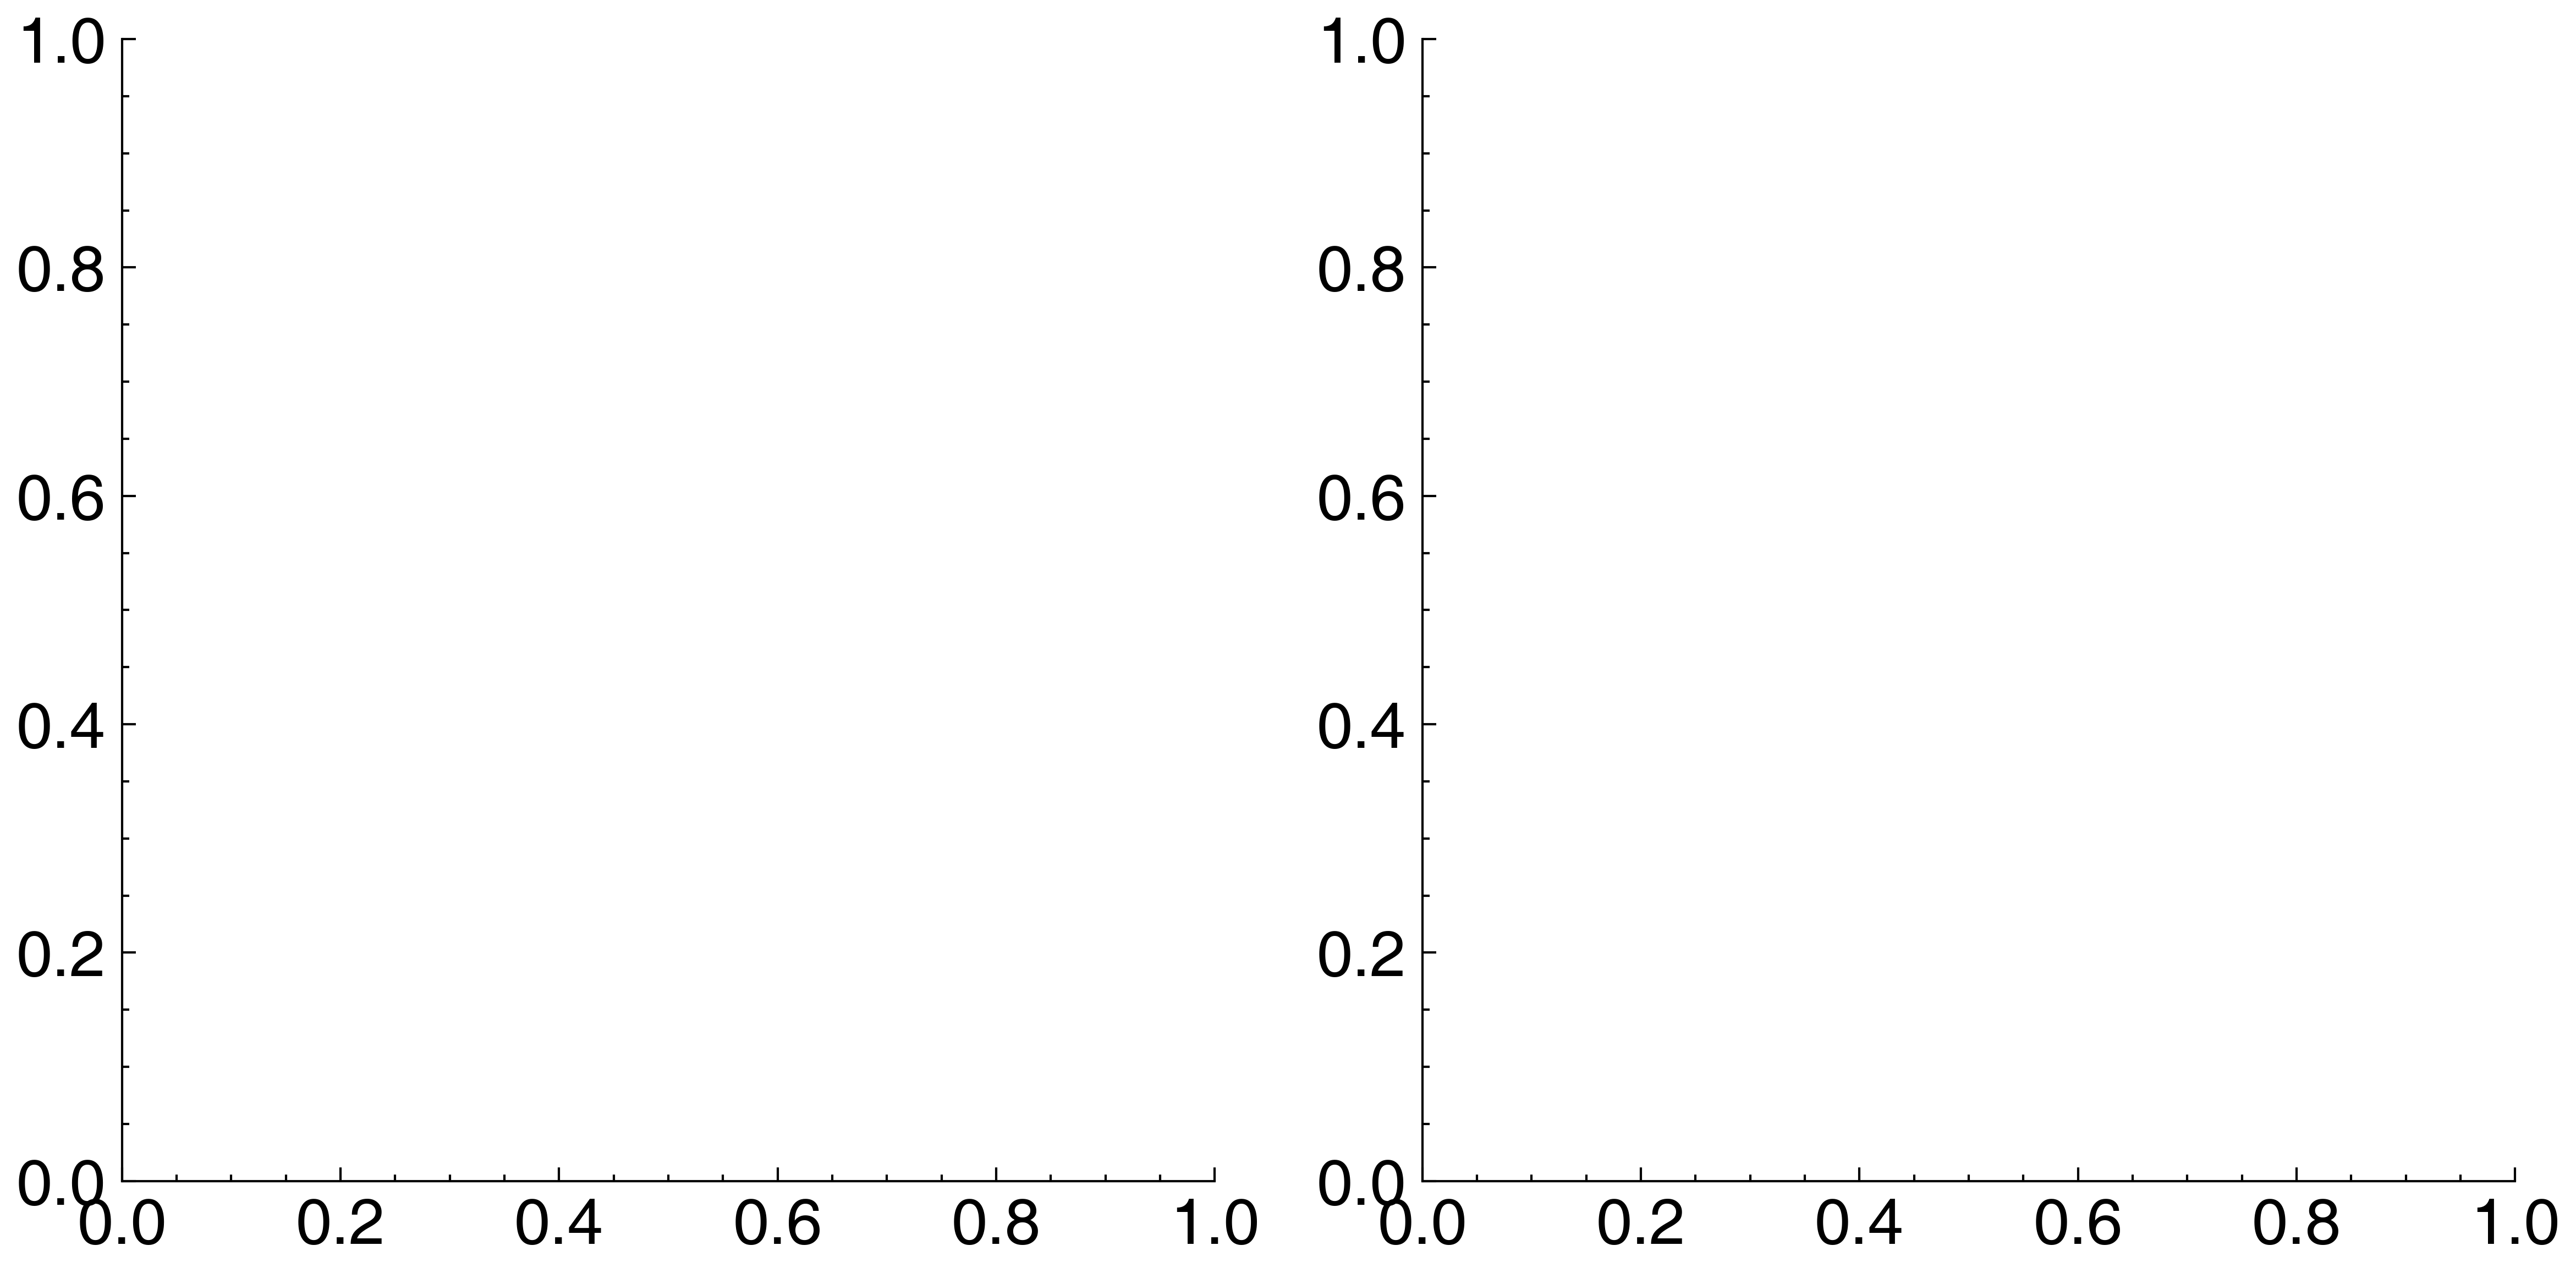

In [37]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
if up_lt_df.shape[0]:
    up_lt_df.transpose().plot(color='lightblue', alpha=0.8, ax=axs[0])
    axs[0].get_legend().remove()
    axs[0].set_ylabel('Coefficient')
    axs[0].plot(up_lt_df.mean(axis=0), color='blue', linestyle='--', marker='o')
    axs[0].set_title('Pre-infection Upregulated\nn=%i'%up_lt_df.shape[0])

if dn_lt_df.shape[0]:
    dn_lt_df.transpose().plot(color='peachpuff', alpha=0.8, ax=axs[1])
    axs[1].get_legend().remove()
    axs[1].set_ylabel('Coefficient')
    #axs[1].plot(dn_lt_df.median(axis=0), color='orange', linestyle='--', marker='o')
    axs[1].plot(dn_lt_df.mean(axis=0), color='red', linestyle='--', marker='o')
    #axs[1].axhline(0, color='blue', alpha=0.75)
    axs[1].set_title('Pre-infection Downregulated\nn=%i'%dn_lt_df.shape[0])
fig.tight_layout()
fig.savefig('%s/10-pre_longitudinal_traj.pdf' % FIGDIR)

Use all events as a positive control:

In [38]:
# Assemble the data frame for High-confidence events (eids)
hc_ltd_df = pd.DataFrame({
    'pre': jem.stats_sheet['final@Pre'].loc[das_eids, 'coefs'],
    'first': jem.stats_sheet['final@First'].loc[das_eids, 'coefs'],
    'mid': jem.stats_sheet['final@Mid'].loc[das_eids, 'coefs'],
    'post': jem.stats_sheet['final@Post'].loc[das_eids, 'coefs'],
    #'late': jem.stats_sheet['final@Late'].loc[das_eids, 'coefs'],
})
hc_up = hc_ltd_df.loc[[e for e in hc_ltd_df.index if e in up_catelog]]
hc_dn = hc_ltd_df.loc[[e for e in hc_ltd_df.index if e in dn_catelog]]

In [39]:
idx = np.where(hc_dn['first'].abs() < 1e-2)[0]
hc_dn.iloc[idx]

pre    first      mid  \
chr2:+:219236009:219236095:219236321:219236651 -0.16393  0.00285 -0.06612   
chr4:+:15686235:15686462:15686931:15687148     -0.01736  0.00830 -0.00669   
chr11:-:418719:418813:418887:418989            -0.04565  0.00931 -0.00497   
chr2:+:101002292:101002315:101002701:101002808  0.04762 -0.00901 -0.03935   
chr1:+:192810165:192810267:192810369:192810431 -0.00815 -0.00885 -0.00841   

                                                   post  
chr2:+:219236009:219236095:219236321:219236651 -0.11420  
chr4:+:15686235:15686462:15686931:15687148     -0.34978  
chr11:-:418719:418813:418887:418989            -0.05148  
chr2:+:101002292:101002315:101002701:101002808 -0.00042  
chr1:+:192810165:192810267:192810369:192810431 -0.00776

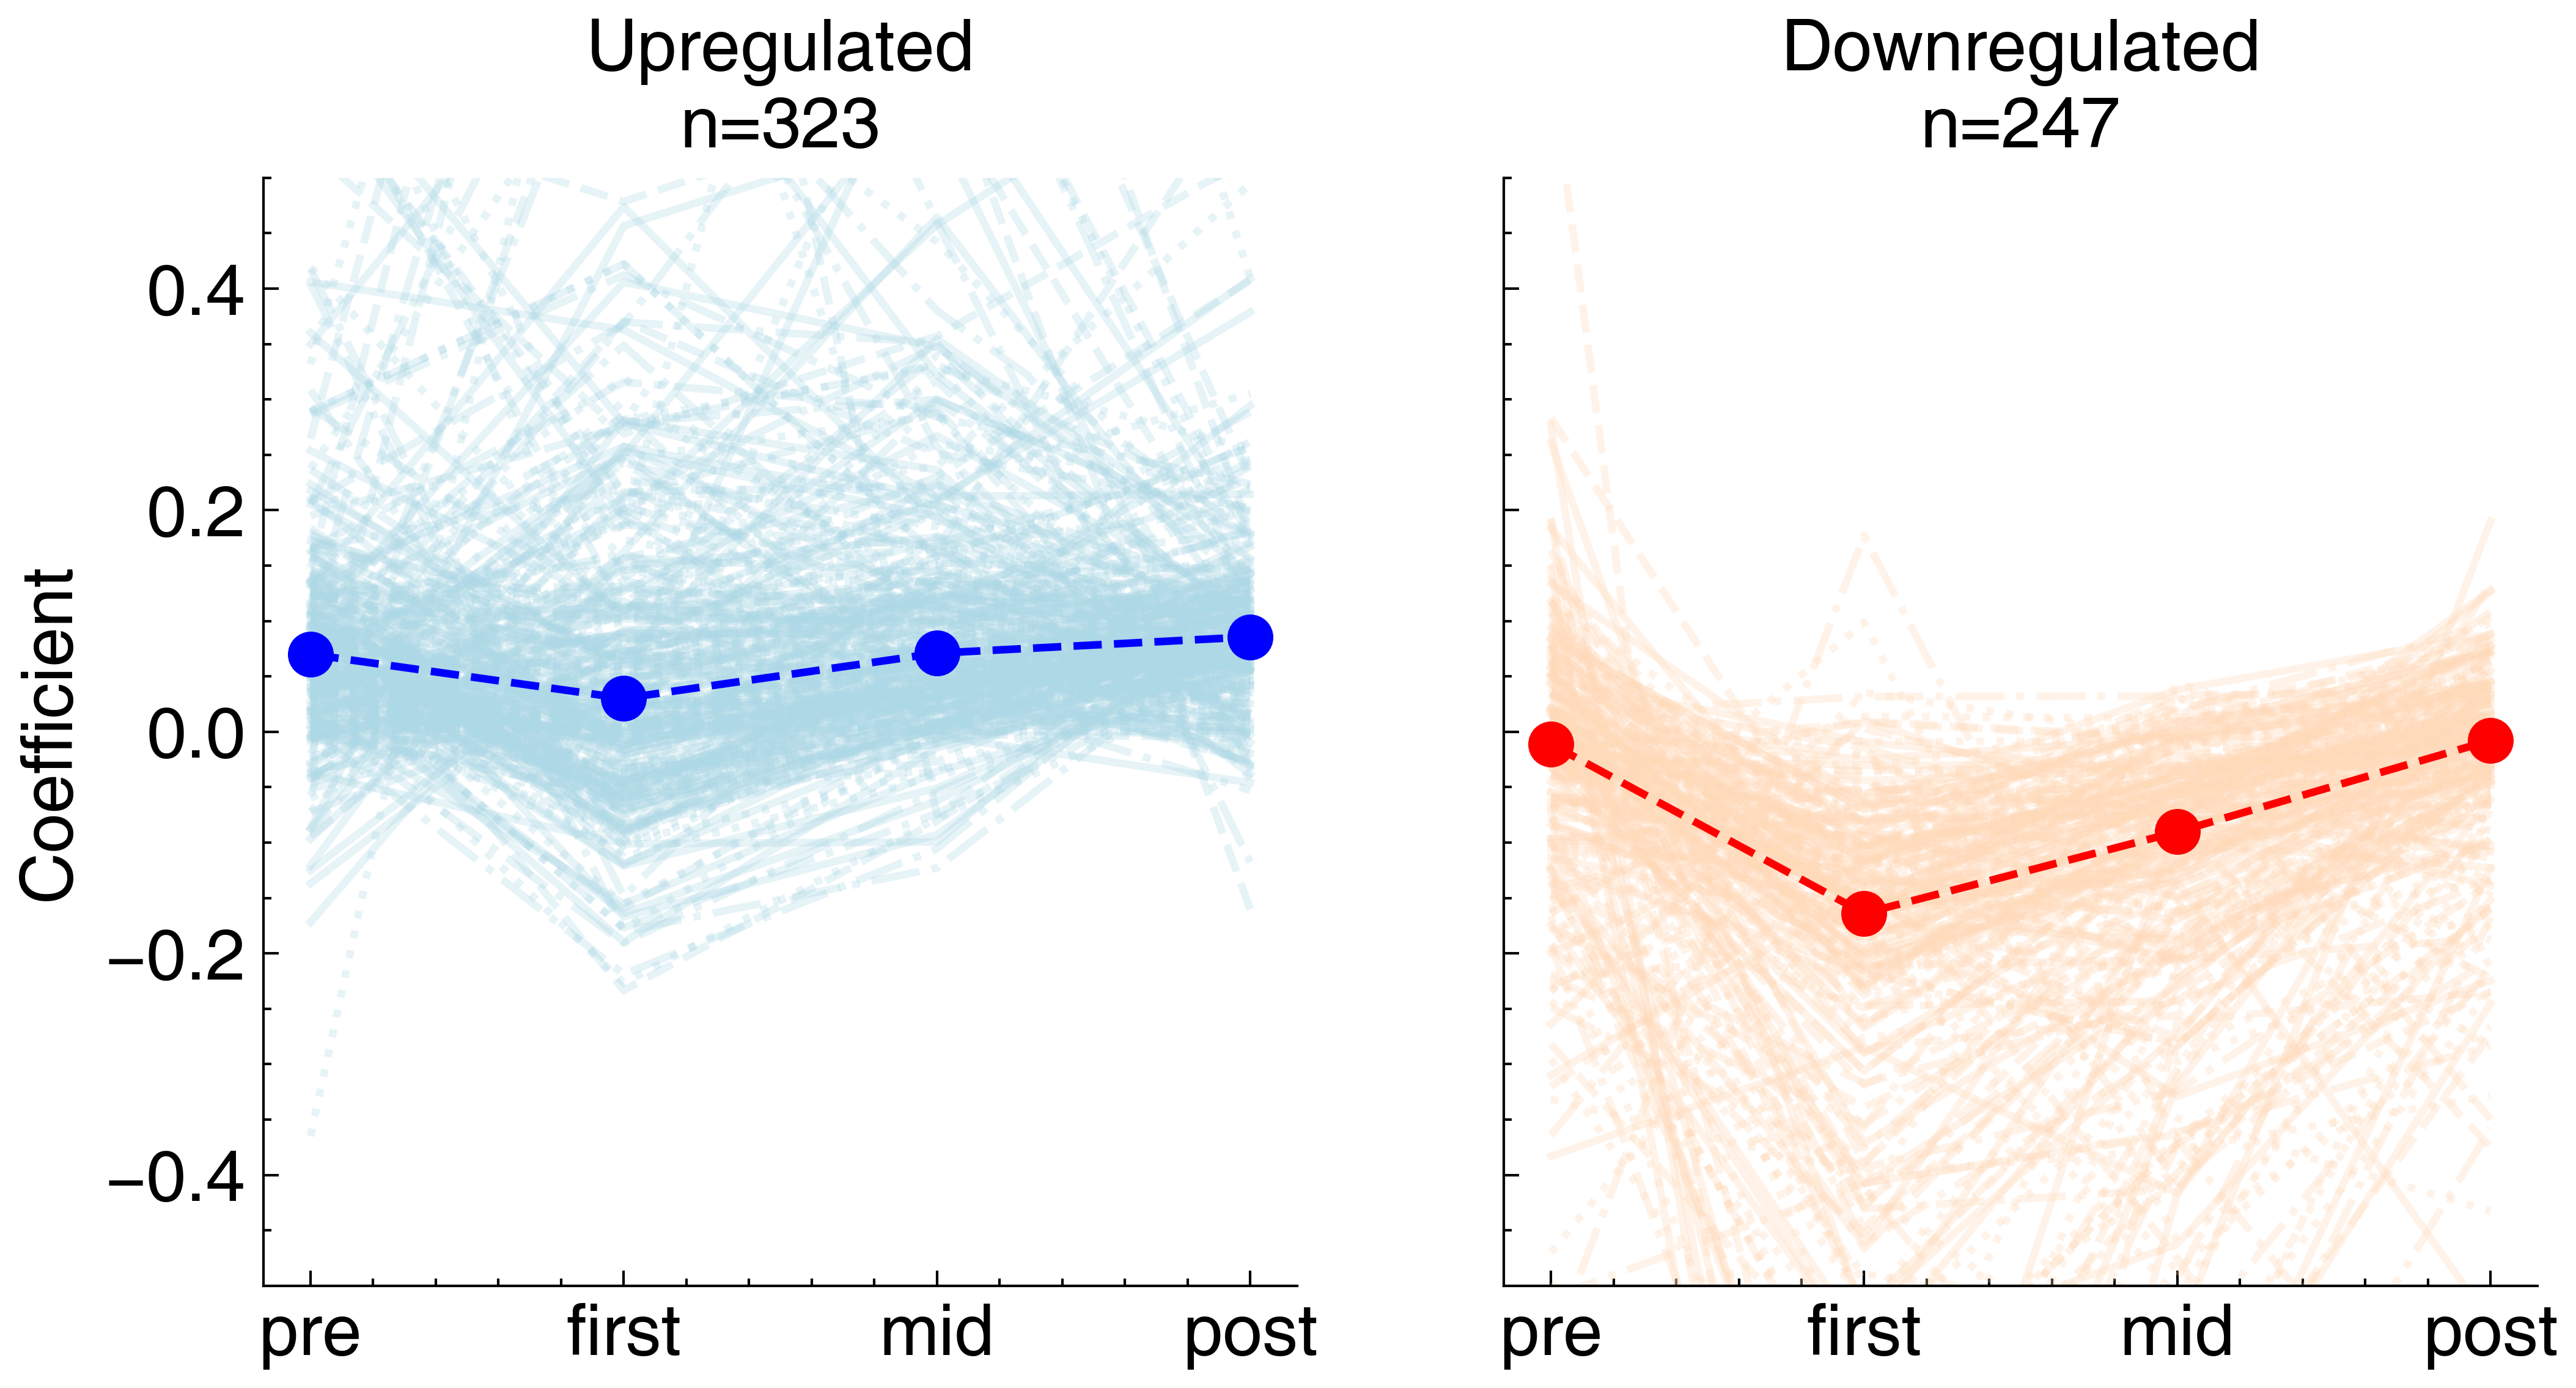

In [40]:
# Plot each event as a line, and the average trend across all events
fig, axs = plt.subplots(1,2, figsize=(8,4), sharey=True)
#fig.suptitle("%s: High-confidence DAS events" % EVENT_TYPE)
hc_up.transpose().plot(color='lightblue', alpha=0.3, ax=axs[0])
ranges = hc_up.apply(lambda x: np.percentile(x, [25, 75]), 0)
#axs[0].fill_between([0,1,2,3], ranges.iloc[0], ranges.iloc[1], color='cornflowerblue', alpha=0.3)
#hc_up.plot(kind='box', ax=axs[0])
#axs[0].plot([1,2,3,4], hc_up.mean(axis=0), color='red', linestyle='--', marker='o')
#axs[0].axhline(0, color='blue', alpha=0.75)
axs[0].get_legend().remove()
axs[0].set_ylabel('Coefficient')
axs[0].plot(np.array([1,2,3,4]) - 1, hc_up.median(axis=0), color='blue', linestyle='--', marker='o')
axs[0].set_title("Upregulated\nn=%i"%hc_up.shape[0])
axs[0].set_ylim(-0.5,0.5)

hc_dn.transpose().plot(color='peachpuff', alpha=0.3, ax=axs[1])
ranges = hc_dn.apply(lambda x: np.percentile(x, [25, 75]), 0)
#axs[1].fill_between([0,1,2,3], ranges.iloc[0], ranges.iloc[1], color='pink', alpha=0.3)
#hc_dn.plot(kind='box', ax=axs[1])
#axs[1].plot([1,2,3,4], hc_dn.mean(axis=0), color='red', linestyle='--', marker='o')
#axs[1].axhline(0, color='blue', alpha=0.75)
#axs[1].set_ylim(-1,1)
axs[1].get_legend().remove()
axs[1].set_ylabel('Coefficient')
axs[1].plot(np.array([1,2,3,4]) -1 , hc_dn.median(axis=0), color='red', linestyle='--', marker='o')
axs[1].set_title("Downregulated\nn=%i"%hc_dn.shape[0])
fig.savefig('%s/10-longitudinal_trajs.pdf' % FIGDIR )

In [41]:
print("FINISH:", datetime.now())

FINISH: 2021-10-24 18:27:58.496859
